In [229]:
import bs4
from bs4 import BeautifulSoup
import requests
import re
import json
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_palette('muted')
sns.set_style('whitegrid')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, \
ExtraTreesRegressor, GradientBoostingRegressor,\
AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, \
RandomForestClassifier, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

## Webscraping

### IMDB: Get film ids

In [230]:
# Function that will make an api call to omdbapi.com and return film id

def get_id_250():
    response = requests.get('http://www.imdb.com/chart/top')
    html = response.text
    entries = re.findall("<a href.*?/title/(.*?)/", html)
    return list(set(entries))

entries = get_id_250()

In [231]:
print len(entries)
print entries[:2]

250
[u'tt2582802', u'tt0047478']


### Fill in film data from omdapi.com

In [232]:
# Function that will make an api call to omdbapi.com and return film data by film id

# Decided to include Rotten Tomatoes ratings and metrics 
# as it may also be a useful feature in models 

# From JSON/APIs lab
def get_entry(entry):
    res = requests.get('http://www.omdbapi.com/?i='+entry+'&plot=full&r=json&tomatoes=true')
    if res.status_code != 200:
        print entry, res.status_code
    else:
        print '.',
    try:
        j = json.loads(res.text)
    except ValueError:
        j = None
    return j

entries_dict_list = [get_entry(e) for e in entries]

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [233]:
len(entries_dict_list)

250

In [234]:
df = pd.DataFrame(entries_dict_list)
df.head(1)

,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,Language,Metascore,Plot,...,tomatoFresh,tomatoImage,tomatoMeter,tomatoRating,tomatoReviews,tomatoRotten,tomatoURL,tomatoUserMeter,tomatoUserRating,tomatoUserReviews
0,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Won 3 Oscars. Another 87 wins & 131 nominations.,N/A,USA,24 Feb 2015,Damien Chazelle,"Drama, Music",English,88,A promising young drummer enrolls at a cut-thr...,...,246,certified,94,8.6,261,15,http://www.rottentomatoes.com/m/whiplash_2014/,94,4.5,66240


In [235]:
print df.shape

(250, 35)


### IMDB: Get gross, opening weekend and budget

In [238]:
def get_gross(entry):
    response = requests.get('http://www.imdb.com/title/' + entry)
    html = response.text
    try:
        gross_list = re.findall("Gross:</h4>[ ]*\$([^ ]*)", html)
        gross = int(gross_list[0].replace(',', ''))
        print '.',
        return gross
    except Exception as ex:
        print
        print ex, entry, response.status_code
        return None

In [239]:
grosses = [(e, get_gross(e)) for e in entries]

. . . . . . .
list index out of range tt0046268 200

list index out of range tt0055630 200
. . . . .
list index out of range tt0057115 200
.
list index out of range tt0071315 200
. . . .
list index out of range tt0074896 200

list index out of range tt1280558 200
.
list index out of range tt0021749 200
. .
list index out of range tt0053125 200
. . .
list index out of range tt1220719 200

list index out of range tt0025316 200
. . . . .
list index out of range tt0072684 200
.
list index out of range tt0074958 200
. . . .
list index out of range tt0036775 200
. . . . . .
list index out of range tt0978762 200

list index out of range tt0109117 200
. .
list index out of range tt0080678 200
. .
list index out of range tt0056592 200
.
list index out of range tt0095327 200
. . .
list index out of range tt0476735 200
. . . . . .
list index out of range tt0046438 200
.
list index out of range tt0015864 200
.
list index out of range tt0045152 200
. . . .
list index out of range tt0046911 200
.
li

In [ ]:
df1 = pd.DataFrame(grosses, columns=['imdbID', 'Gross'])
df1.head(3)

In [ ]:
def get_opening(entry):
    response = requests.get('http://www.imdb.com/title/' + entry)
    html = response.text
    try:
        opening_list = re.findall("Opening Weekend:</h4>[ ]*\$([^ ]*)", html)
        opening = int(opening_list[0].replace(',', ''))
        print '.',
        return opening
    except Exception as ex:
        print
        print ex, entry, response.status_code
        return None

In [240]:
opening = [(e, get_opening(e)) for e in entries]

. . .
list index out of range tt0050212 200

list index out of range tt0986264 200
. .
list index out of range tt0046268 200

list index out of range tt0055630 200
. . . . .
list index out of range tt0057115 200
.
list index out of range tt0071315 200

list index out of range tt0114746 200
. . .
list index out of range tt0074896 200

list index out of range tt1280558 200
.
list index out of range tt0021749 200
.
list index out of range tt1187043 200

list index out of range tt0053125 200
.
list index out of range tt0112471 200
.
list index out of range tt1220719 200

list index out of range tt0025316 200
. .
list index out of range tt0088247 200
.
list index out of range tt0087843 200

list index out of range tt0072684 200
.
list index out of range tt0074958 200
.
list index out of range tt0052618 200
. .
list index out of range tt0036775 200
.
list index out of range tt0110357 200
. . .
list index out of range tt0075148 200

list index out of range tt0978762 200

list index out of ran

In [241]:
df2 = pd.DataFrame(opening, columns=['imdbID', 'Opening'])
df2.head(3)

,imdbID,Opening
0,tt2582802,135388.0
1,tt0047478,21830.0
2,tt0082971,1673731.0


In [242]:
def get_budget(entry):
    response = requests.get('http://www.imdb.com/title/' + entry)
    html = response.text
    try:
        budget_list = re.findall("Budget:</h4>[ ]*\$([^ ]*)", html)
        budget = int(budget_list[0].replace(',', ''))
        print '.',
        return budget
    except Exception as ex:
        print
        print ex, entry, response.status_code
        return None

In [243]:
budgets = [(e, get_budget(e)) for e in entries]

. . . .
list index out of range tt0986264 200
. .
list index out of range tt0046268 200

list index out of range tt0055630 200
. . . . . . . . .
list index out of range tt0363163 200
.
list index out of range tt1865505 200
.
list index out of range tt1280558 200
. . .
list index out of range tt1187043 200
. . . . . . . . . . . . . . . . . . . . . .
list index out of range tt0071853 200
. .
list index out of range tt0978762 200

list index out of range tt0109117 200
. . . . . . . . . . .
list index out of range tt0476735 200
.
list index out of range tt0044741 200
. . . .
list index out of range tt0046438 200
. . . . . . . .
list index out of range tt0046911 200
.
list index out of range tt0050986 200
.
list index out of range tt0091251 200
. . . . .
list index out of range tt0113247 200
. . . . . . . . . . .
list index out of range tt0060827 200
. .
list index out of range tt0211915 200
. . . . . . .
list index out of range tt0053198 200
. . . . . . . . . .
list index out of range tt00

In [244]:
df3 = pd.DataFrame(budgets, columns=['imdbID', 'Budget'])
df3.head()

,imdbID,Budget
0,tt2582802,3300000.0
1,tt0047478,2000000.0
2,tt0082971,18000000.0
3,tt0050212,3000000.0
4,tt0986264,NaN


In [245]:
print df1.columns
print df2.columns
print df3.columns

Index([u'imdbID', u'Gross'], dtype='object')
Index([u'imdbID', u'Opening'], dtype='object')
Index([u'imdbID', u'Budget'], dtype='object')


In [246]:
df_gross = df1.copy()
df_opening = df2.copy()
df_budget = df3.copy()

In [247]:
print df_gross.columns, df_gross.shape
print df_opening.columns, df_opening.shape
print df_budget.columns, df_opening.shape

Index([u'imdbID', u'Gross'], dtype='object') (250, 2)
Index([u'imdbID', u'Opening'], dtype='object') (250, 2)
Index([u'imdbID', u'Budget'], dtype='object') (250, 2)


### Merge all dataframes into 1 master df

In [248]:
# Merge gross, opening and budget dfs
df_imdb = pd.merge(df_gross, df_opening, on="imdbID")
df_imdb = pd.merge(df_imdb, df_budget, on="imdbID")
df_imdb.head(3)

,imdbID,Gross,Opening,Budget
0,tt2582802,13092000.0,135388.0,3300000.0
1,tt0047478,269061.0,21830.0,2000000.0
2,tt0082971,242374454.0,1673731.0,18000000.0


In [249]:
# Merge original df (from omdbapi) with df_imdb
df = pd.merge(df, df_imdb)
print df.shape
df.head(3)

(249, 38)


,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,Language,Metascore,Plot,...,tomatoRating,tomatoReviews,tomatoRotten,tomatoURL,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,Gross,Opening,Budget
0,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Won 3 Oscars. Another 87 wins & 131 nominations.,N/A,USA,24 Feb 2015,Damien Chazelle,"Drama, Music",English,88,A promising young drummer enrolls at a cut-thr...,...,8.6,261,15,http://www.rottentomatoes.com/m/whiplash_2014/,94,4.5,66240,13092000.0,135388.0,3300000.0
1,"Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Nominated for 2 Oscars. Another 5 wins & 6 nom...,N/A,Japan,01 Mar 1999,Akira Kurosawa,"Action, Adventure, Drama",Japanese,98,"A veteran samurai, who has fallen on hard time...",...,9.3,57,0,http://www.rottentomatoes.com/m/1018639-seven_...,97,4.5,89264,269061.0,21830.0,2000000.0
2,"Harrison Ford, Karen Allen, Paul Freeman, Rona...",Won 4 Oscars. Another 30 wins & 23 nominations.,N/A,USA,21 Oct 2003,Steven Spielberg,"Action, Adventure","English, German, Hebrew, Spanish, Arabic, Nepali",85,The year is 1936. An archeology professor name...,...,9.2,71,4,http://www.rottentomatoes.com/m/raiders_of_the...,96,4.1,823555,242374454.0,1673731.0,18000000.0


In [23]:
#################
#################

# Copy of merged raw dfs without dropping/rearranging columns or cleaning
#dfc1 = df.copy()

#################
#################

### Reorder and drop columns

In [301]:
df.columns = [i.encode('utf-8') for i in df.columns]
df.columns.values

array(['Actors', 'Awards', 'BoxOffice', 'Country', 'DVD', 'Director',
       'Genre', 'Language', 'Metascore', 'Plot', 'Poster', 'Production',
       'Rated', 'Released', 'Response', 'Runtime', 'Title', 'Type',
       'Website', 'Writer', 'Year', 'imdbID', 'imdbRating', 'imdbVotes',
       'tomatoConsensus', 'tomatoFresh', 'tomatoImage', 'tomatoMeter',
       'tomatoRating', 'tomatoReviews', 'tomatoRotten', 'tomatoURL',
       'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', 'Gross',
       'Opening', 'Budget'], dtype=object)

In [302]:
original_cols = df.columns.values
cols_list = [
    'imdbID', 'Title', 
    'BoxOffice', 'Gross', 'Opening', 'Budget', 
    'Year', 'Released', 
    'Metascore', 'imdbRating', 'imdbVotes',
    'tomatoMeter', 'tomatoRating', 'tomatoReviews', 
    'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', 
    'tomatoFresh', 'tomatoRotten',
    'Awards', 'Actors', 'Director', 'Writer', 'Production',  
    'Country', 'Language', 'Genre', 'Rated', 'Runtime', 'Plot', 
    'tomatoConsensus', 'tomatoImage',  'tomatoURL',
    'Website',  'DVD',  'Poster', 'Type', 'Response']

# columns to delete:
# ['tomatoConsensus', 'tomatoImage',  'tomatoURL', 'Response',
# 'Type', 'Poster', 'Website', 'DVD']

print len(original_cols)
print len(cols_list)

38
38


In [303]:
print df['Type'].value_counts()
print df['Response'].value_counts()

movie    250
Name: Type, dtype: int64
True    250
Name: Response, dtype: int64


In [304]:
# Reindex column order
df = df.reindex(columns=cols_list)
print df.shape
print df.columns.values
df.head(1)

(250, 38)
['imdbID' 'Title' 'BoxOffice' 'Gross' 'Opening' 'Budget' 'Year' 'Released'
 'Metascore' 'imdbRating' 'imdbVotes' 'tomatoMeter' 'tomatoRating'
 'tomatoReviews' 'tomatoUserMeter' 'tomatoUserRating' 'tomatoUserReviews'
 'tomatoFresh' 'tomatoRotten' 'Awards' 'Actors' 'Director' 'Writer'
 'Production' 'Country' 'Language' 'Genre' 'Rated' 'Runtime' 'Plot'
 'tomatoConsensus' 'tomatoImage' 'tomatoURL' 'Website' 'DVD' 'Poster'
 'Type' 'Response']


,imdbID,Title,BoxOffice,Gross,Opening,Budget,Year,Released,Metascore,imdbRating,...,Runtime,Plot,tomatoConsensus,tomatoImage,tomatoURL,Website,DVD,Poster,Type,Response
0,tt2582802,Whiplash,N/A,13092000.0,135388.0,3300000.0,2014,15 Oct 2014,88,8.5,...,107 min,A promising young drummer enrolls at a cut-thr...,"Intense, inspiring, and well-acted, Whiplash i...",certified,http://www.rottentomatoes.com/m/whiplash_2014/,http://sonyclassics.com/whiplash/,24 Feb 2015,https://images-na.ssl-images-amazon.com/images...,movie,True


In [305]:
cols_to_delete = ['tomatoConsensus', 'tomatoImage',  'tomatoURL', 'Response',
                  'Type', 'Poster', 'Website', 'DVD']

In [306]:
# Create final master df with only 30 columns
df = df[['imdbID', 'Title', 
    'BoxOffice', 'Gross', 'Opening', 'Budget', 
    'Year', 'Released', 
    'Metascore', 'imdbRating', 'imdbVotes',
    'tomatoMeter', 'tomatoRating', 'tomatoReviews', 
    'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', 
    'tomatoFresh', 'tomatoRotten',
    'Awards', 'Actors', 'Director', 'Writer', 'Production',  
    'Country', 'Language', 'Genre', 'Rated', 'Runtime', 'Plot']]

print df.shape
df.head(2)

(250, 30)


,imdbID,Title,BoxOffice,Gross,Opening,Budget,Year,Released,Metascore,imdbRating,...,Actors,Director,Writer,Production,Country,Language,Genre,Rated,Runtime,Plot
0,tt2582802,Whiplash,N/A,13092000.0,135388.0,3300000.0,2014,15 Oct 2014,88,8.5,...,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Damien Chazelle,Damien Chazelle,Sony Pictures Classics,USA,English,"Drama, Music",R,107 min,A promising young drummer enrolls at a cut-thr...
1,tt0047478,Seven Samurai,N/A,269061.0,21830.0,2000000.0,1954,19 Nov 1956,98,8.7,...,"Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Akira Kurosawa,"Akira Kurosawa (screenplay), Shinobu Hashimoto...",Columbia Pictures,Japan,Japanese,"Action, Adventure, Drama",UNRATED,207 min,"A veteran samurai, who has fallen on hard time..."


In [261]:
#######################
#######################

# Copy of merged df with columns cleaned
#dfc2 = df.copy()

#######################
#######################

In [262]:
#df.to_csv('film_dfc2.csv', sep=',', encoding='utf-8')

## Data Cleaning / Munging

### Converting dtypes

In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 30 columns):
imdbID               250 non-null object
Title                250 non-null object
BoxOffice            61 non-null object
Gross                183 non-null float64
Opening              118 non-null float64
Budget               213 non-null float64
Year                 250 non-null int64
Released             249 non-null object
Metascore            167 non-null float64
imdbRating           250 non-null float64
imdbVotes            250 non-null object
tomatoMeter          243 non-null float64
tomatoRating         243 non-null float64
tomatoReviews        243 non-null float64
tomatoUserMeter      247 non-null float64
tomatoUserRating     247 non-null float64
tomatoUserReviews    249 non-null float64
tomatoFresh          243 non-null float64
tomatoRotten         243 non-null float64
Awards               246 non-null object
Actors               250 non-null object
Director             25

### Convert numeric dtypes (floats and int)

In [311]:
# Convert Metascore to float with np.nan for N/A
df['Metascore'] = df['Metascore'].apply(lambda x: np.nan if x == 'N/A' else x)
df['Metascore'] = df['Metascore'].astype(float)

In [312]:
# Convert imdbRating to float
df['imdbRating'] = df['imdbRating'].astype(float)

In [313]:
# Convert imdbVotes to int
df['imdbVotes'] = df['imdbVotes'].apply(lambda x: x.replace(',', ''))
df['imdbVotes'] = df['imdbVotes'].astype(int)

In [ ]:
# Convert all tomato columns to float
tomato_list = ['tomatoMeter', 'tomatoReviews', 'tomatoUserMeter', 'tomatoUserReviews',
           'tomatoFresh', 'tomatoRotten', 'tomatoRating', 'tomatoUserRating']

def convert_num(some_list):
    for i in some_list:
        df[i] = df[i].apply(lambda x: np.nan if x == 'N/A' else x)
        df[i] = df[i].astype(float)
    return df[i]

convert_num(tomato_list)

### Convert datetime-related columns (Year, Released and Runtime)

In [315]:
# Convert Year to int
df['Year'] = df['Year'].astype(int)

In [316]:
df.columns

Index([u'imdbID', u'Title', u'BoxOffice', u'Gross', u'Opening', u'Budget',
       u'Year', u'Released', u'Metascore', u'imdbRating', u'imdbVotes',
       u'tomatoMeter', u'tomatoRating', u'tomatoReviews', u'tomatoUserMeter',
       u'tomatoUserRating', u'tomatoUserReviews', u'tomatoFresh',
       u'tomatoRotten', u'Awards', u'Actors', u'Director', u'Writer',
       u'Production', u'Country', u'Language', u'Genre', u'Rated', u'Runtime',
       u'Plot'],
      dtype='object')

In [317]:
# Extract month from release date
df['Month'] = [x[3:6] for x in df['Released']]

In [318]:
# Convert Release to datetime

# Only N/A value is Charlie Chaplin's The Gold Rush
df['Released'] = ['1925-06-25' if i == 'N/A' else datetime.strptime(str(i), '%d %b %Y') \
                 for i in df['Released']]
df['Released'].head(3)

0   2014-10-15
1   1956-11-19
2   1981-06-12
Name: Released, dtype: datetime64[ns]

In [319]:
# Extract numeric month from release date
df['Num_Month'] = df['Released'].dt.month
df['Num_Month'].head(3)

0    10
1    11
2     6
Name: Num_Month, dtype: int64

In [320]:
# Create new season bins for release dates

# Only missing value is Charlie Chaplin's The Gold Rush
winter = ['Jan', 'Feb', 'Mar', 'Apr']
summer = ['May', 'Jun', 'Jul']
fall = ['Aug', 'Sep', 'Oct']
holiday = ['Nov', 'Dec']

def bin_months(i):
    if i in winter:
        i = 'Winter'
    elif i in summer:
        i = 'Summer'
    elif i in fall:
        i = 'Fall'
    elif i in holiday:
        i = 'Holiday'
    else:
        i = 'Summer'
    return i

df['Season'] = [bin_months(x) for x in df['Month']]
df['Season'].value_counts()

Winter     83
Fall       59
Summer     58
Holiday    50
Name: Season, dtype: int64

In [321]:
# Convert Runtime to int
def runtime_int(x):
    return int(x.replace(' min', ''))

df['Runtime'] = df['Runtime'].apply(runtime_int)
df['Runtime'].head(2)

0    107
1    207
Name: Runtime, dtype: int64

### Clean up Awards, Rating and Genres

In [322]:
df['Awards'].head()

0     Won 3 Oscars. Another 87 wins & 131 nominations.
1    Nominated for 2 Oscars. Another 5 wins & 6 nom...
2      Won 4 Oscars. Another 30 wins & 23 nominations.
3       Won 7 Oscars. Another 23 wins & 7 nominations.
4                            14 wins & 15 nominations.
Name: Awards, dtype: object

In [323]:
# Make Oscars_Won column with number of Oscars won
def oscar_winners(x):
    try:
        oscar_winner = re.findall(r'([^.]*?Oscar[^.]*\.)',x)[0].split()
        if type(oscar_winner[0]) == int:
            return int(oscar_winner[0])
        elif oscar_winner[0] == 'Won':
            return int(oscar_winner[1])
        else:
            return 0
    except:
        return 0
    
df['Oscars_Won'] = df['Awards'].apply(oscar_winners)
df['Oscars_Won'].head(3)

0    3
1    0
2    4
Name: Oscars_Won, dtype: int64

In [324]:
# Make Oscar_Noms columns
def oscar_noms(x):
    try:
        oscar_noms = re.findall('Nominated\sfor\s(\d)\sOscar',x)[0]
        return int(oscar_noms)
    except:
        return 0

df['Oscar_Noms'] = df['Awards'].apply(oscar_noms)
df['Oscar_Noms'].value_counts()

0    179
1     28
2     12
4      9
3      8
5      6
7      4
6      3
8      1
Name: Oscar_Noms, dtype: int64

In [325]:
# Make Awards_Won column with sum of other awards won
def awards_won(x):
    try:
        awards_won = re.findall('Another\s(\d+)\swins', x)[0]
        return int(awards_won)
    except:
        return 0

df['Awards_Won'] = df['Awards'].apply(awards_won)
df['Awards_Won'].head(3)

0    87
1     5
2    30
Name: Awards_Won, dtype: int64

In [326]:
# Make Other_Noms column with sum of other nominations
def other_noms(x):
    try:
        other_noms = re.findall('(\d+)\snomination', x)[0]
        return int(other_noms)
    except:
        return 0

df['Other_Noms'] = df['Awards'].apply(other_noms)
df['Other_Noms'].head(3)

0    131
1      6
2     23
Name: Other_Noms, dtype: int64

In [327]:
# Clean up Rating column
print df['Rated'].value_counts()
rated_other = ['NOT RATED', 'APPROVED', 'UNRATED', 'PASSED', 'N/A', 'M']

df['Rated'] = df['Rated'].apply(lambda x: x if x not in rated_other else 'OTHER')
df['Rated'].value_counts()

R            104
PG            38
PG-13         32
NOT RATED     24
APPROVED      20
G             12
UNRATED        9
PASSED         6
N/A            4
M              1
Name: Rated, dtype: int64


R        104
OTHER     64
PG        38
PG-13     32
G         12
Name: Rated, dtype: int64

In [328]:
# Clean up Genre column
df['Genre_1'] = df['Genre'].apply(lambda x: x.split(',')[0])
df['Genre_1'].value_counts()

Drama        68
Crime        40
Action       34
Adventure    28
Comedy       27
Biography    20
Animation    19
Mystery       5
Horror        3
Western       3
Film-Noir     2
Sci-Fi        1
Name: Genre_1, dtype: int64

In [329]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 249
Data columns (total 38 columns):
imdbID               250 non-null object
Title                250 non-null object
BoxOffice            250 non-null object
Gross                182 non-null float64
Opening              117 non-null float64
Budget               212 non-null float64
Year                 250 non-null int64
Released             250 non-null datetime64[ns]
Metascore            166 non-null float64
imdbRating           250 non-null float64
imdbVotes            250 non-null int64
tomatoMeter          241 non-null float64
tomatoRating         241 non-null float64
tomatoReviews        241 non-null float64
tomatoUserMeter      247 non-null float64
tomatoUserRating     247 non-null float64
tomatoUserReviews    249 non-null float64
tomatoFresh          241 non-null float64
tomatoRotten         241 non-null float64
Awards               250 non-null object
Actors               250 non-null object
Director       

In [289]:
#######################
#######################

# Copy of cleaned df
#dfc3 = df.copy()

#######################
#######################

In [292]:
#dfc3.to_csv('dfc3.csv', sep=',', encoding='utf-8')

### Fill in missing values

In [330]:
df.isnull().sum()

imdbID                 0
Title                  0
BoxOffice              0
Gross                 68
Opening              133
Budget                38
Year                   0
Released               0
Metascore             84
imdbRating             0
imdbVotes              0
tomatoMeter            9
tomatoRating           9
tomatoReviews          9
tomatoUserMeter        3
tomatoUserRating       3
tomatoUserReviews      1
tomatoFresh            9
tomatoRotten           9
Awards                 0
Actors                 0
Director               0
Writer                 0
Production             0
Country                0
Language               0
Genre                  0
Rated                  0
Runtime                0
Plot                   0
Month                  0
Num_Month              0
Season                 0
Oscars_Won             0
Oscar_Noms             0
Awards_Won             0
Other_Noms             0
Genre_1                0
dtype: int64

In [331]:
# Drop columns with a large proportion of missing values 
# (columns whose values are difficult to impute)
# Also drop Language column as English is most common language
cols_to_drop2 = ['Opening', 'Budget', 'Language']
df.drop(['Opening', 'Budget', 'Language'], axis=1, inplace=True)

In [332]:
# For columns with small number of missing values, fill missing values
# with median column values

df['tomatoMeter'].fillna((df['tomatoMeter'].median()), inplace=True)
df['tomatoRating'].fillna((df['tomatoRating'].median()), inplace=True)
df['tomatoReviews'].fillna((df['tomatoReviews'].median()), inplace=True)
df['tomatoUserMeter'].fillna((df['tomatoUserMeter'].median()), inplace=True)
df['tomatoUserRating'].fillna((df['tomatoUserRating'].median()), inplace=True)
df['tomatoUserReviews'].fillna((df['tomatoUserReviews'].median()), inplace=True)
df['tomatoFresh'].fillna((df['tomatoFresh'].median()), inplace=True)
df['tomatoRotten'].fillna((df['tomatoRotten'].median()), inplace=True)

df.isnull().sum()

imdbID                0
Title                 0
BoxOffice             0
Gross                68
Year                  0
Released              0
Metascore            84
imdbRating            0
imdbVotes             0
tomatoMeter           0
tomatoRating          0
tomatoReviews         0
tomatoUserMeter       0
tomatoUserRating      0
tomatoUserReviews     0
tomatoFresh           0
tomatoRotten          0
Awards                0
Actors                0
Director              0
Writer                0
Production            0
Country               0
Genre                 0
Rated                 0
Runtime               0
Plot                  0
Month                 0
Num_Month             0
Season                0
Oscars_Won            0
Oscar_Noms            0
Awards_Won            0
Other_Noms            0
Genre_1               0
dtype: int64

#### Metascore Corr. Heatmaps

In [333]:
# Check correlation between score metrics to see if I can drop Metascore and use
# another as a good proxy
df.loc[:, ['Metascore', 'tomatoMeter', 'tomatoRating']].corr()

,Metascore,tomatoMeter,tomatoRating
Metascore,1.000000,0.717221,0.804335
tomatoMeter,0.717221,1.000000,0.834344
tomatoRating,0.804335,0.834344,1.000000


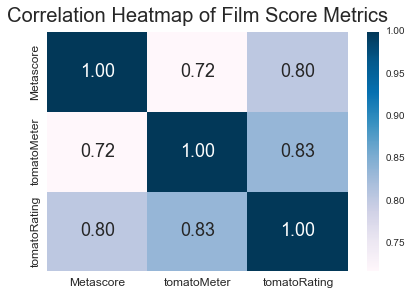

In [334]:
# Plot correlation heatmap
score_df = df[['Metascore', 'tomatoMeter', 'tomatoRating']]
plt.figure(figsize=(6,4))
ax = sns.heatmap(score_df.corr(), cmap='PuBu', annot=True, annot_kws={'size': 18}, \
                fmt='.2f')
ax.set_title('Correlation Heatmap of Film Score Metrics', y=1.02)
ax.tick_params(axis='both', labelsize=12)
plt.savefig('score_df_heatmap.png')

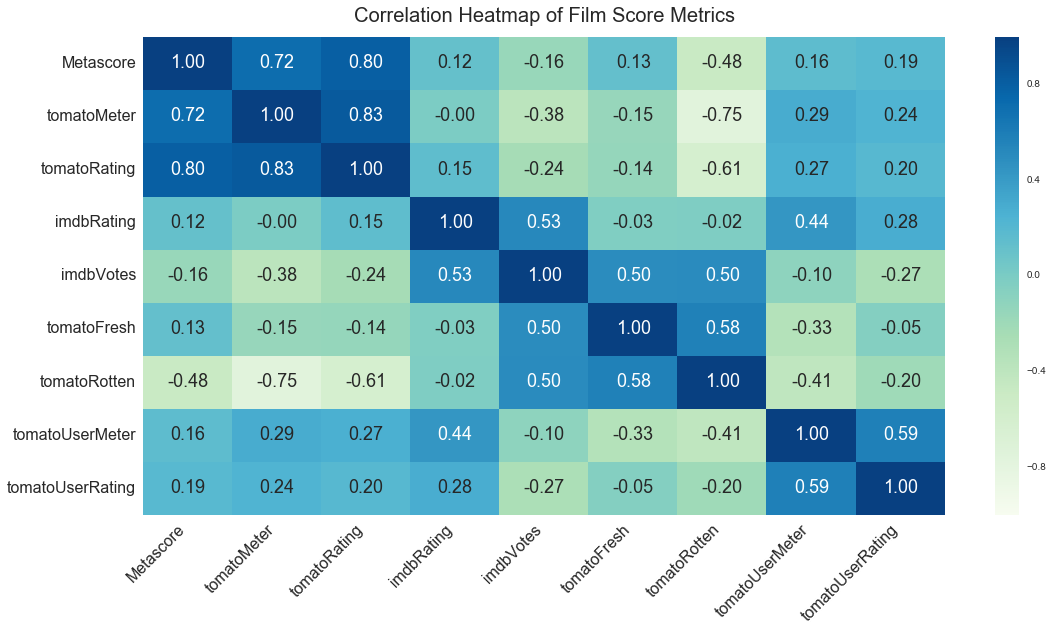

In [335]:
score_df2 = df[['Metascore', 'tomatoMeter', 'tomatoRating', 
               'imdbRating', 'imdbVotes', 'tomatoFresh', 'tomatoRotten', 
               'tomatoUserMeter', 'tomatoUserRating']]
plt.figure(figsize=(16,8))
ax = sns.heatmap(score_df2.corr(), cmap='GnBu', annot=True, annot_kws={'size': 18}, \
                fmt='.2f')
ax.set_title('Correlation Heatmap of Film Score Metrics', y=1.02)
ax.set_xticklabels(score_df2.columns, rotation=45, horizontalalignment='right')
ax.tick_params(axis='both', labelsize=16, )
plt.savefig('score_df2_heatmap.png')

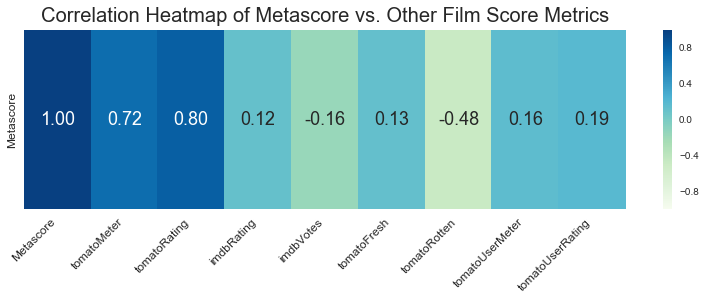

In [336]:
metascore_corr = score_df2.corr().ix[['Metascore']]
plt.figure(figsize=(12,3))
ax = sns.heatmap(metascore_corr, cmap='GnBu', annot=True, annot_kws={'size': 18}, \
                fmt='.2f')
ax.set_title('Correlation Heatmap of Metascore vs. Other Film Score Metrics', y=1.02)
ax.set_xticklabels(score_df2.columns, rotation=45, horizontalalignment='right')
ax.tick_params(axis='both', labelsize=12 )
plt.savefig('metascore_heatmap.png')

In [337]:
# Drop Metascore as it is highly correlated to both tomatoMeter and tomatoRating
df.drop('Metascore', inplace=True, axis=1)

### Try to fill in missing values for Gross column with linear regression

In [338]:
summary = df.describe()
summary1 = pd.DataFrame(summary.loc[:, 'Gross'].apply(lambda x: '{0: ,.2f}'.format(x)))
summary1

,Gross
count,182.00
mean,"105,384,604.24"
std,"134,480,357.25"
min,"10,177.00"
25%,"8,072,547.75"
50%,"51,943,707.00"
75%,"162,003,486.00"
max,"936,627,416.00"


#### Unused pairplot

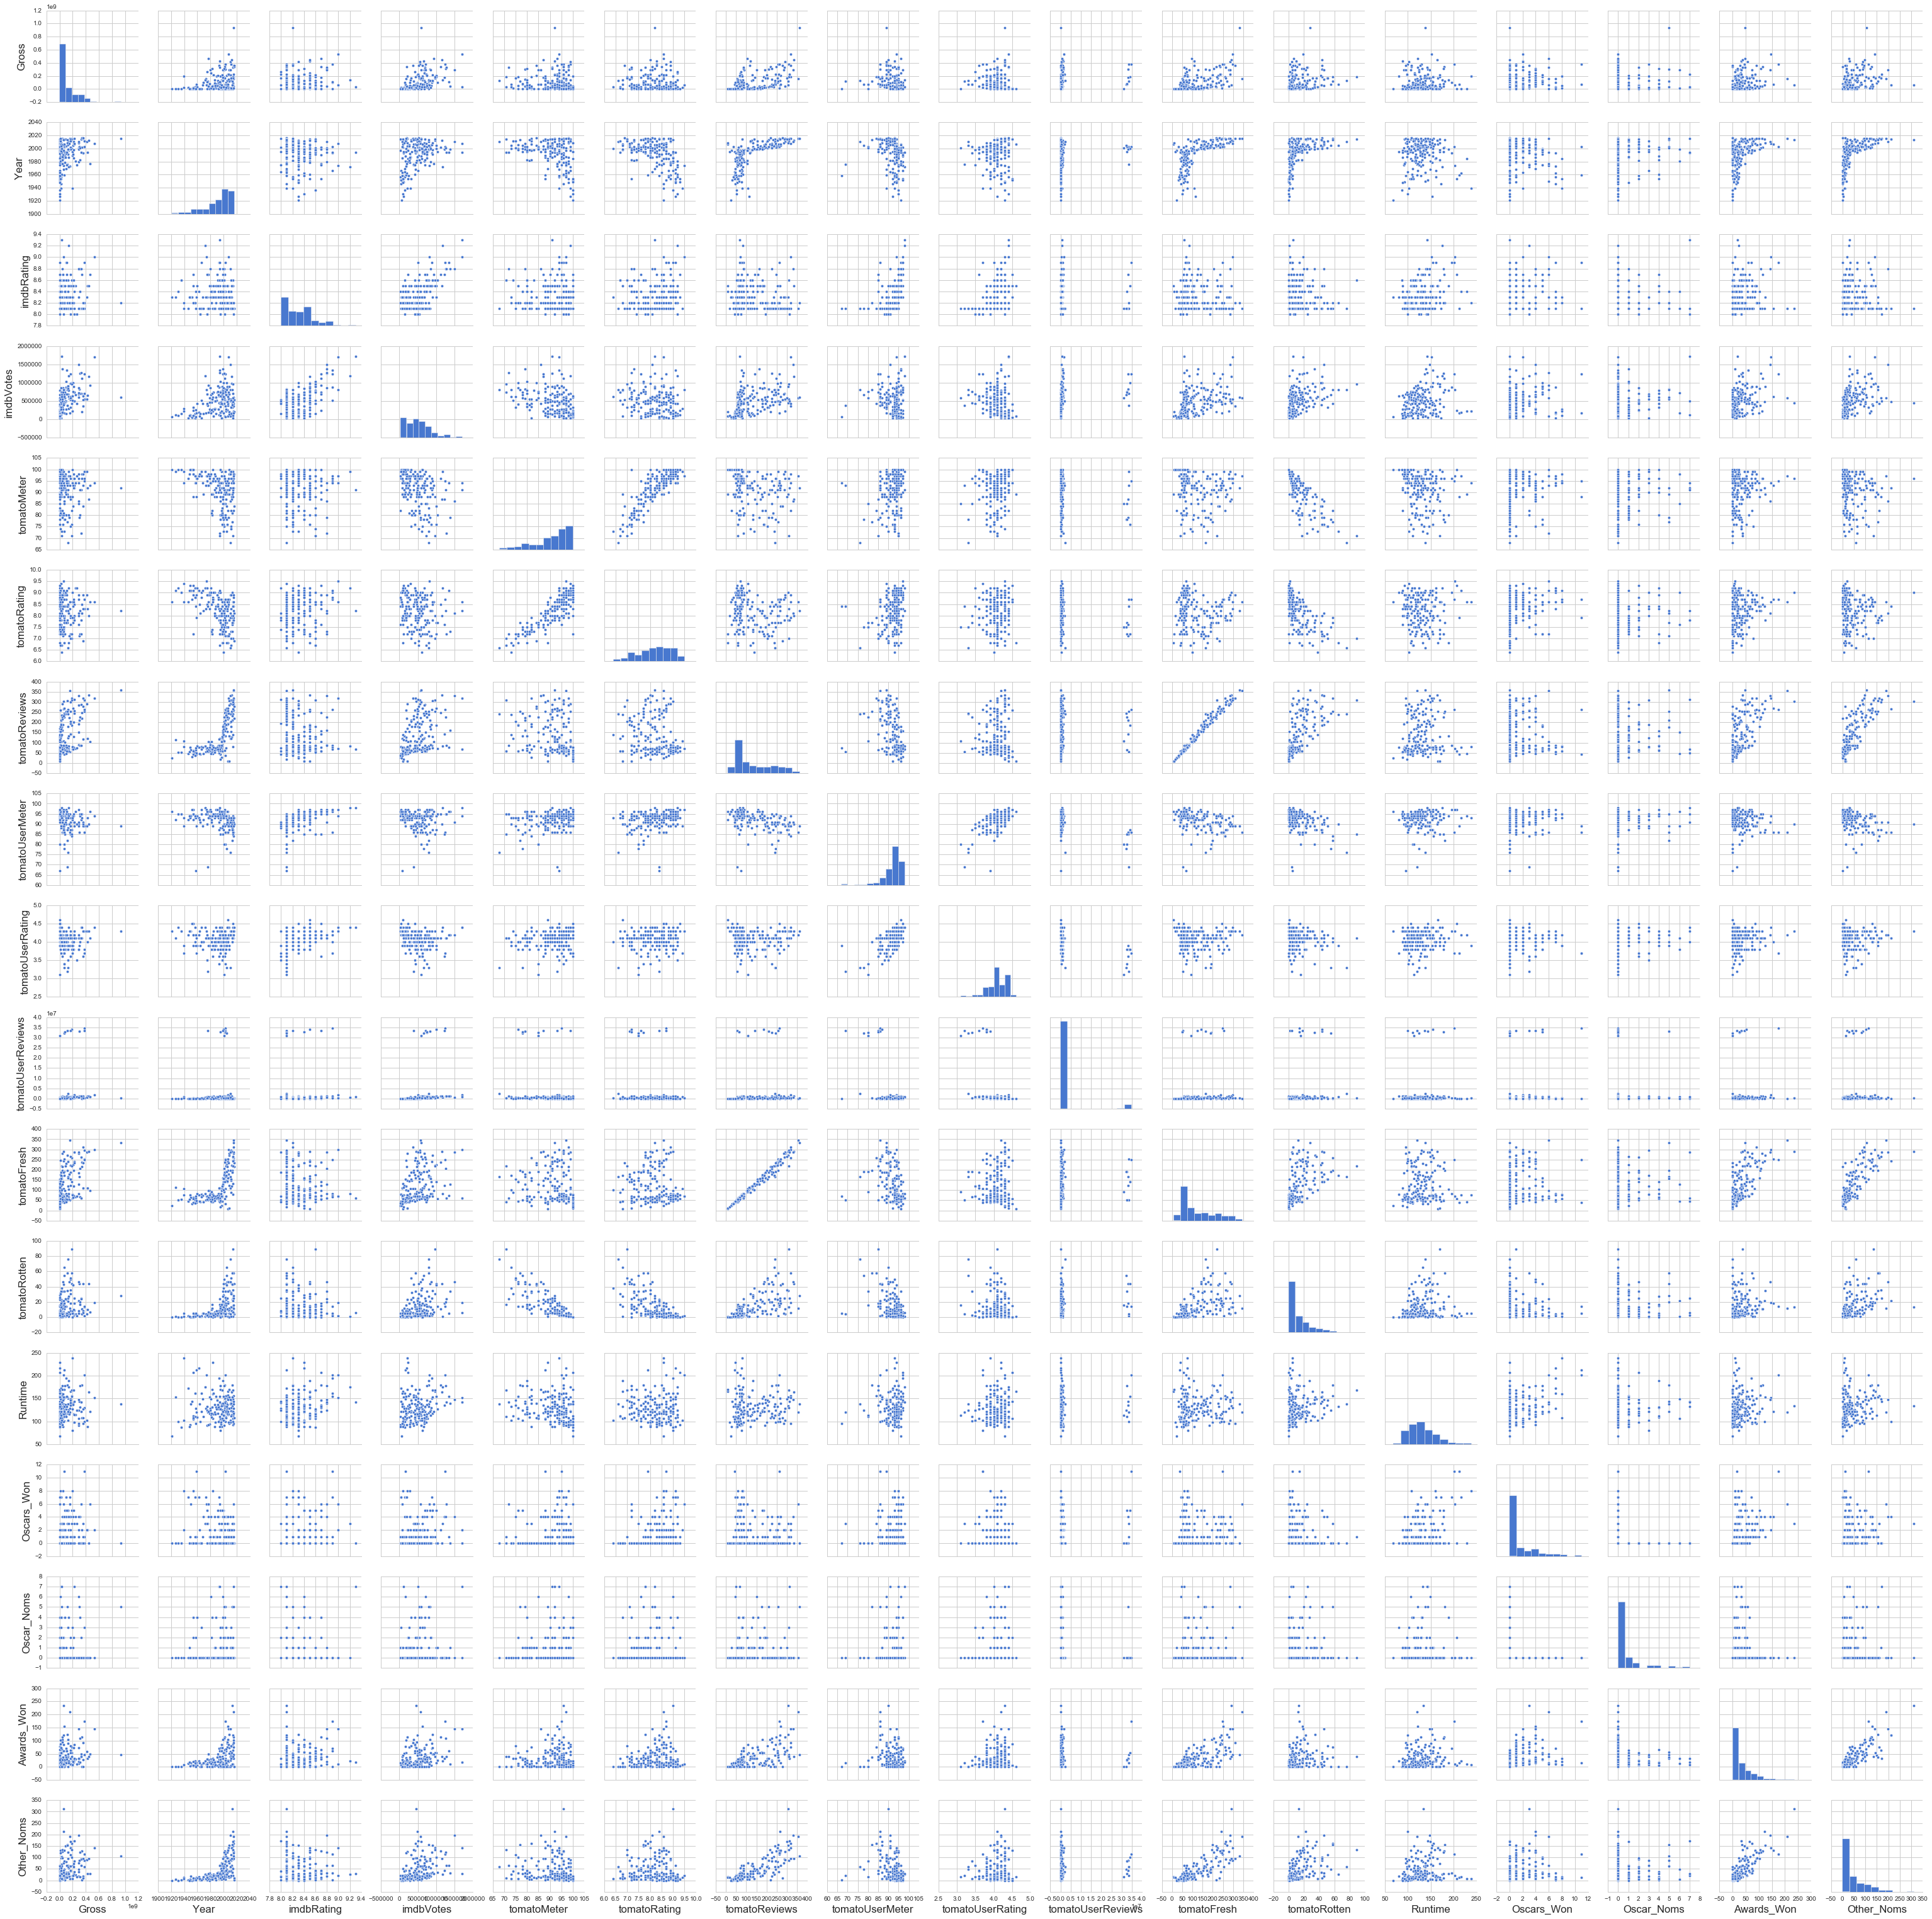

In [339]:
#sns.pairplot(lm_test)

#### Pairplots

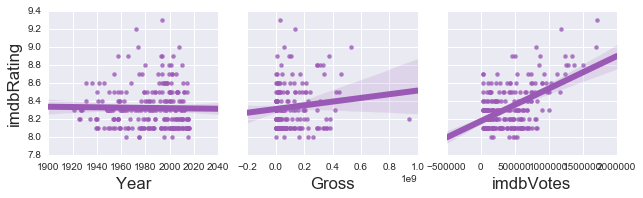

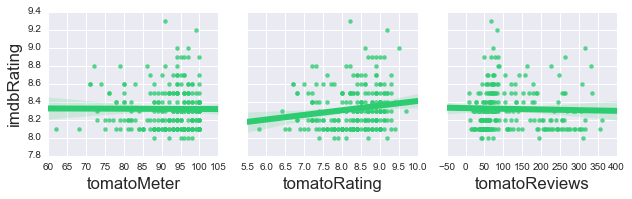

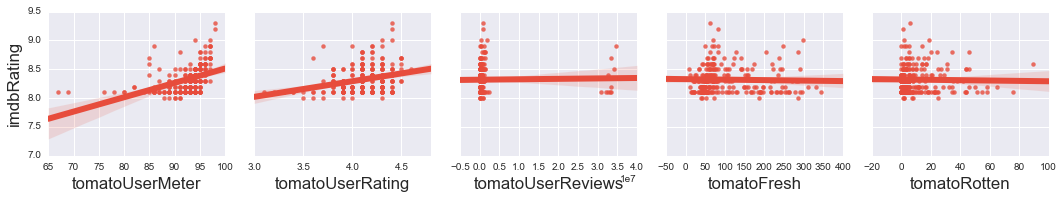

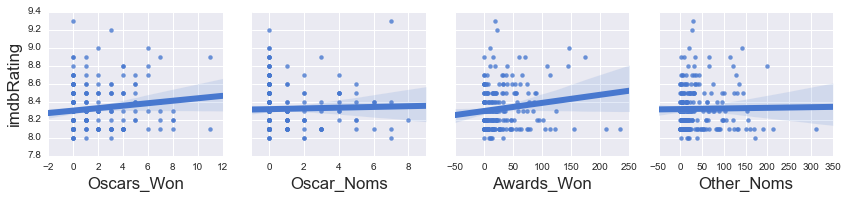

In [376]:
#imdbRating vs. Features

sns.set_style('darkgrid')
pal1 = ["#9b59b6"]
pal2 = ["#2ecc71"]
pal3 = ["#e74c3c"]

sns.set_palette(pal1)
rating_plot1 = sns.PairGrid(df, y_vars=['imdbRating'], x_vars=['Year', 'Gross', 'imdbVotes'], 
                 size=3)
rating_plot1.map(sns.regplot)

sns.set_palette(pal2)
rating_plot2 = sns.PairGrid(df, y_vars=['imdbRating'], x_vars=['tomatoMeter', 
                 'tomatoRating', 'tomatoReviews'], 
                 size=3, palette='muted')
rating_plot2.map(sns.regplot)

sns.set_palette(pal3)
rating_plot3 = sns.PairGrid(df, y_vars=['imdbRating'], x_vars=['tomatoUserMeter', 'tomatoUserRating', 
                 'tomatoUserReviews', 'tomatoFresh', 'tomatoRotten'], 
                 size=3)
rating_plot3.map(sns.regplot)

sns.set_palette('muted')
rating_plot4 = sns.PairGrid(df, y_vars=['imdbRating'], x_vars=['Oscars_Won', 'Oscar_Noms', 
                 'Awards_Won', 'Other_Noms'], 
                 size=3)
rating_plot4.map(sns.regplot)

plt.savefig('imdbRating_regplots.png')

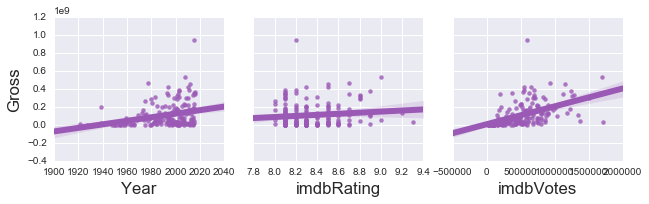

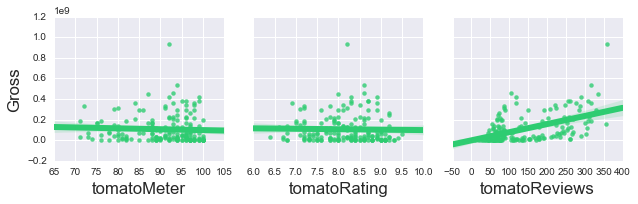

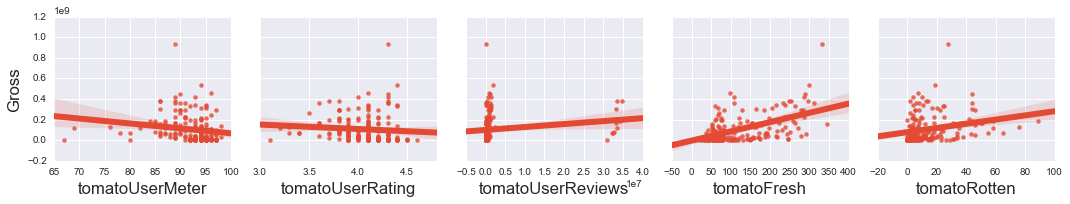

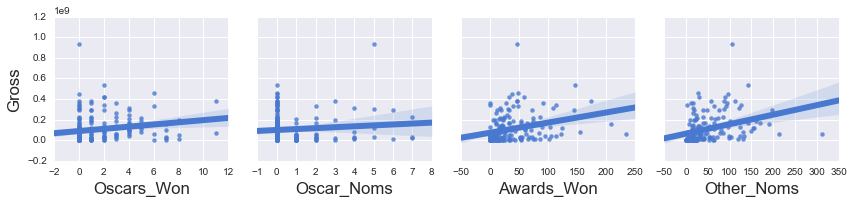

In [377]:
#Gross vs. Features

pal1 = ["#9b59b6"]
pal2 = ["#2ecc71"]
pal3 = ["#e74c3c"]

sns.set_palette(pal1)
gross_plot1 = sns.PairGrid(df, y_vars=['Gross'], x_vars=['Year', 'imdbRating', 'imdbVotes'], 
                 size=3)
gross_plot1.map(sns.regplot)

sns.set_palette(pal2)
gross_plot2 = sns.PairGrid(df, y_vars=['Gross'], x_vars=['tomatoMeter', 
                 'tomatoRating', 'tomatoReviews'], 
                 size=3, palette='muted')
gross_plot2.map(sns.regplot)

sns.set_palette(pal3)
gross_plot3 = sns.PairGrid(df, y_vars=['Gross'], x_vars=['tomatoUserMeter', 'tomatoUserRating', 
                 'tomatoUserReviews', 'tomatoFresh', 'tomatoRotten'], 
                 size=3)
gross_plot3.map(sns.regplot)

sns.set_palette('muted')
gross_plot4 = sns.PairGrid(df, y_vars=['Gross'], x_vars=['Oscars_Won', 'Oscar_Noms', 
                 'Awards_Won', 'Other_Noms'], 
                 size=3)
gross_plot4.map(sns.regplot)

plt.savefig('gross_regplots.png')

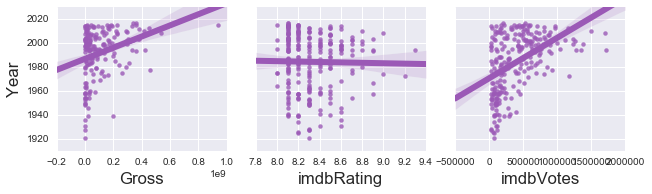

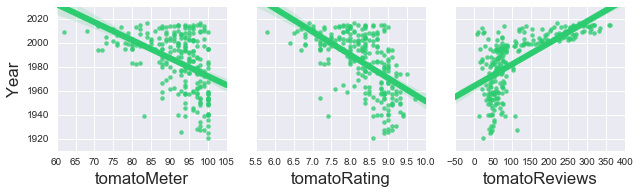

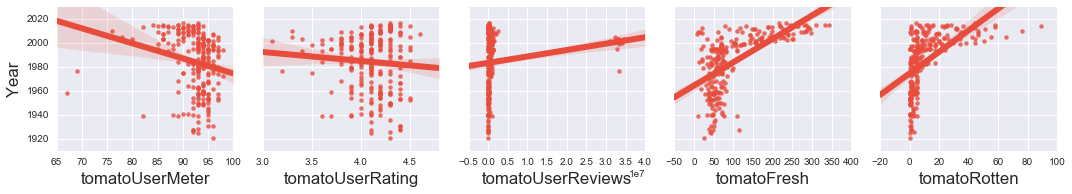

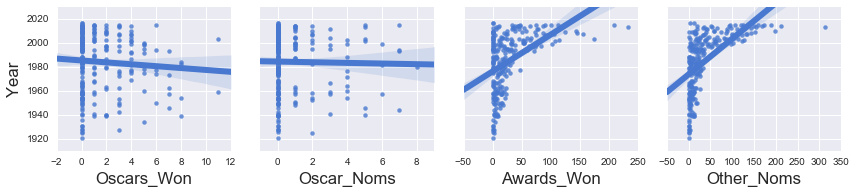

In [380]:
#Year vs. Features

pal1 = ["#9b59b6"]
pal2 = ["#2ecc71"]
pal3 = ["#e74c3c"]

sns.set_palette(pal1)
year_plot1 = sns.PairGrid(df, y_vars=['Year'], x_vars=['Gross', 'imdbRating', 'imdbVotes'], 
                 size=3)
year_plot1.map(sns.regplot)
year_plot1.set(ylim=(1910, 2030))

sns.set_palette(pal2)
year_plot2 = sns.PairGrid(df, y_vars=['Year'], x_vars=['tomatoMeter', 
                 'tomatoRating', 'tomatoReviews'], 
                 size=3, palette='muted')
year_plot2.map(sns.regplot)
year_plot2.set(ylim=(1910, 2030))

sns.set_palette(pal3)
year_plot3 = sns.PairGrid(df, y_vars=['Year'], x_vars=['tomatoUserMeter', 'tomatoUserRating', 
                 'tomatoUserReviews', 'tomatoFresh', 'tomatoRotten'], 
                 size=3)
year_plot3.map(sns.regplot)
year_plot3.set(ylim=(1910, 2030))

sns.set_palette('muted')
year_plot4 = sns.PairGrid(df, y_vars=['Year'], x_vars=['Oscars_Won', 'Oscar_Noms', 
                 'Awards_Won', 'Other_Noms'], 
                 size=3)
year_plot4.map(sns.regplot)
year_plot4.set(ylim=(1910, 2030))

plt.savefig('year_regplots.png')

#### Heatmaps

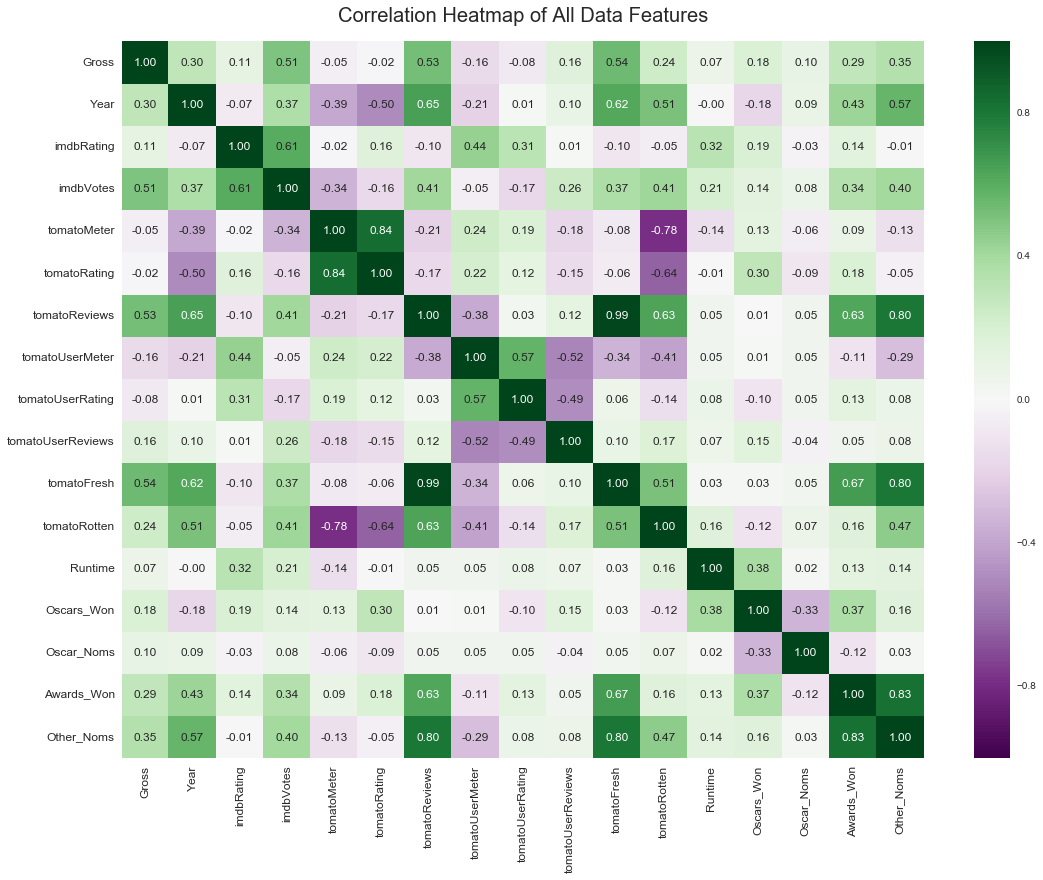

In [340]:
plt.figure(figsize=(16,12))
ax = sns.heatmap(lm_test.corr(), cmap='PRGn', annot=True, annot_kws={'size': 12}, \
                fmt='.2f')
ax.set_title('Correlation Heatmap of All Data Features', y=1.02)
#ax.set_xticklabels(lm_cols[:-1], rotation=45, horizontalalignment='right')
ax.tick_params(axis='both', labelsize=12 )
plt.savefig('lm_test_heatmap.png')

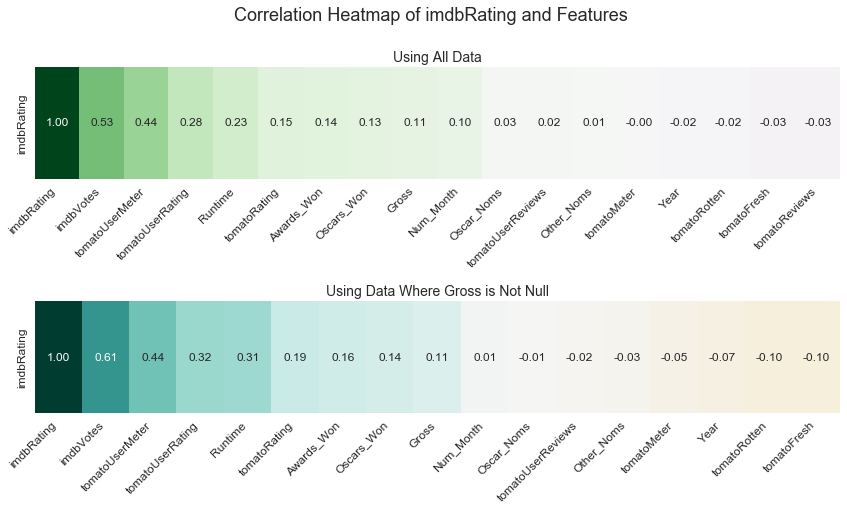

In [381]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=.1, right=None, top=.9, wspace=None, hspace=1.1)
plt.suptitle('Correlation Heatmap of imdbRating and Features', y=1.04, fontsize=18)

rating_corr = df.corr().ix[['imdbRating']].sort_values('imdbRating', \
                                                       axis=1, ascending=False)
sns.heatmap(rating_corr, cmap='PRGn', annot=True, annot_kws={'size': 12}, \
                fmt='.2f', ax=ax1, cbar=False)
ax1.set_title('Using All Data', fontsize=14, y=1.01)
ax1.set_xticklabels(rating_corr.columns, rotation=45, horizontalalignment='right')
ax1.tick_params(axis='both', labelsize=12 )

rating_corr2 = lm_test.corr().ix[['imdbRating']].sort_values('imdbRating', \
                                                             axis=1, ascending=False)
sns.heatmap(rating_corr2, cmap='BrBG', annot=True, annot_kws={'size': 12}, \
                fmt='.2f', ax=ax2, cbar=False)
ax2.set_title('Using Data Where Gross is Not Null', fontsize=14, y=1.01)
ax2.set_xticklabels(rating_corr.columns, rotation=45, horizontalalignment='right')
ax2.tick_params(axis='both', labelsize=12 )

plt.savefig('lm_test_imdb_rating_heatmap.png')

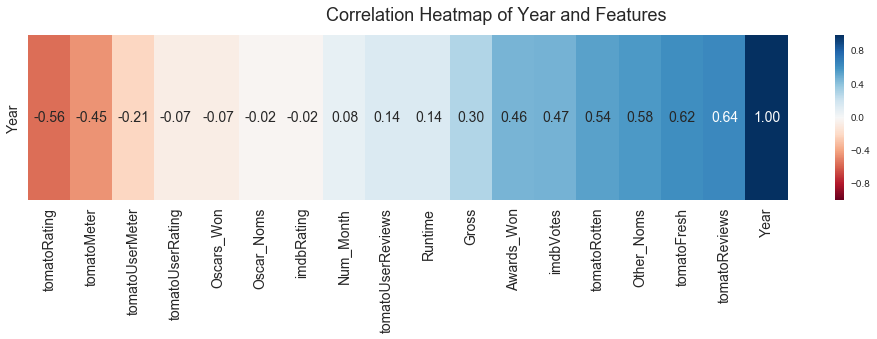

In [404]:
fig, ax1 = plt.subplots(figsize=(14,3))
fig.tight_layout()
plt.suptitle('Correlation Heatmap of Year and Features', y=1.04, fontsize=18)

year_corr = df.corr().ix[['Year']].sort_values('Year', axis=1)
sns.heatmap(year_corr, cmap='RdBu', annot=True, annot_kws={'size': 14}, \
                fmt='.2f', ax=ax1, cbar=True)
ax.set_xticklabels(year_corr.columns, horizontalalignment='right')
plt.tick_params(axis='both', labelsize=14)

plt.savefig('lm_test_year_heatmap.png')

#### Linear Regression for Gross missing values

In [433]:
months = pd.get_dummies(df['Num_Month'], prefix='Months')
months.head(3)

lm = pd.concat([df, months], axis=1)
lm.head(1)

,imdbID,Title,BoxOffice,Gross,Year,Released,imdbRating,imdbVotes,tomatoMeter,tomatoRating,...,Months_3,Months_4,Months_5,Months_6,Months_7,Months_8,Months_9,Months_10,Months_11,Months_12
0,tt2582802,Whiplash,N/A,13092000.0,2014,2014-10-15,8.5,413720,94.0,8.6,...,0,0,0,0,0,0,0,1,0,0


In [434]:
lm_test = lm[lm['Gross'].notnull() == True] 
lm_pred = lm[lm['Gross'].notnull() == False] 

In [436]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lm = LinearRegression()
X = lm_test[['imdbRating', 'imdbVotes', 'tomatoMeter', \
              'tomatoRating', 'tomatoReviews', 'tomatoUserMeter', 'tomatoUserRating', \
              'tomatoUserReviews', 'tomatoFresh', 'tomatoRotten', 'Year', 'Oscars_Won', \
            'Oscar_Noms', 'Awards_Won', 'Other_Noms', 'Runtime', 
            'Months_1', 'Months_2', 'Months_3', 'Months_4', 'Months_5', 'Months_6',
            'Months_7', 'Months_8', 'Months_9', 'Months_10', 'Months_11', 'Months_12']]
y = lm_test['Gross']

linear = lm.fit(X, y)
y_pred = linear.predict(X)


print 'model_score:', linear.score(X, y)
print 'MSE:', mean_squared_error(y, y_pred)
print 'coeffs: ', linear.coef_
print ''
print '***Note: Model score is too low to predict missing gross revenue values***'
print '***Note: Will try to use model predictions in future iterations of notebook***'

model_score: 0.610941204353
MSE: 6.99745530612e+15
coeffs:  [ -1.24390071e+08   2.45717433e+02   1.04006517e+06  -1.78047817e+07
   7.43286903e+06  -5.59179452e+05   6.79523932e+07   1.91370687e-01
  -6.25090142e+06  -9.02746331e+06  -2.35196621e+05   1.58118126e+07
   8.78586795e+06  -8.82484237e+05  -4.89203385e+05  -2.10649847e+05
  -1.19544984e+07   6.98021862e+06  -4.45130897e+07  -5.33027662e+06
   2.94085259e+07   5.29123411e+07   5.55299086e+07   5.40152288e+06
  -4.63491334e+07  -7.05139272e+07  -2.69089709e+06   3.11193052e+07]

***Note: Model score is too low to predict missing gross revenue values***
***Note: Will try to use model predictions in future iterations of notebook***


#### Linear Model Coeffs

In [437]:
coeffs = []
labels = ['imdbRating', 'imdbVotes', 'tomatoMeter', \
              'tomatoRating', 'tomatoReviews', 'tomatoUserMeter', 'tomatoUserRating', \
              'tomatoUserReviews', 'tomatoFresh', 'tomatoRotten', 'Year', 'Oscars_Won', \
            'Oscar_Noms', 'Awards_Won', 'Other_Noms', 'Runtime', 
            'Months_1', 'Months_2', 'Months_3', 'Months_4', 'Months_5', 'Months_6',
            'Months_7', 'Months_8', 'Months_9', 'Months_10', 'Months_11', 'Months_12']
coef = list(linear.coef_)
coeffs.append(labels)
coeffs.append(coef)
pd.DataFrame(coeffs).T

,0,1
0,imdbRating,-1.2439e+08
1,imdbVotes,245.717
2,tomatoMeter,1.04007e+06
3,tomatoRating,-1.78048e+07
4,tomatoReviews,7.43287e+06
5,tomatoUserMeter,-559179
6,tomatoUserRating,6.79524e+07
7,tomatoUserReviews,0.191371
8,tomatoFresh,-6.2509e+06
9,tomatoRotten,-9.02746e+06


#### Model score of 0.610 is too low to predict missing gross values

### Fill in missing Gross values with median

In [ ]:
# Tried to fill in missing Gross values with BoxOffice values but no results

In [438]:
lm_test.corr().loc[:, ['Gross']]

,Gross
Gross,1.000000
Year,0.302139
imdbRating,0.110845
imdbVotes,0.505039
tomatoMeter,-0.048190
tomatoRating,-0.022032
tomatoReviews,0.527701
tomatoUserMeter,-0.159849
tomatoUserRating,-0.082485
tomatoUserReviews,0.159074


In [439]:
corr_index = lm_test.corr().loc['tomatoFresh', 'Gross']
corr_index
# Gross is most correlated with tomatoFresh

0.53981753140357369

In [440]:
df['Gross'].median()

51943707.0

In [441]:
# I attempted to standardize Gross and fill in for missing values by making
# an adjusted Gross column which is the Gross * corr_index or median Gross *
# corr_index for missing values (so Gross is represented in relation to corr_index)

gross_median = df['Gross'].median()
df['Adj_Gross'] = df['Gross'].apply(lambda x: x * corr_index if x > 0 else\
                                   gross_median * corr_index)

print df['Adj_Gross'].isnull().sum()
df['Adj_Gross'].head()

0


0    7.067291e+06
1    1.452438e+05
2    1.308380e+08
3    1.468304e+07
4    6.502966e+05
Name: Adj_Gross, dtype: float64

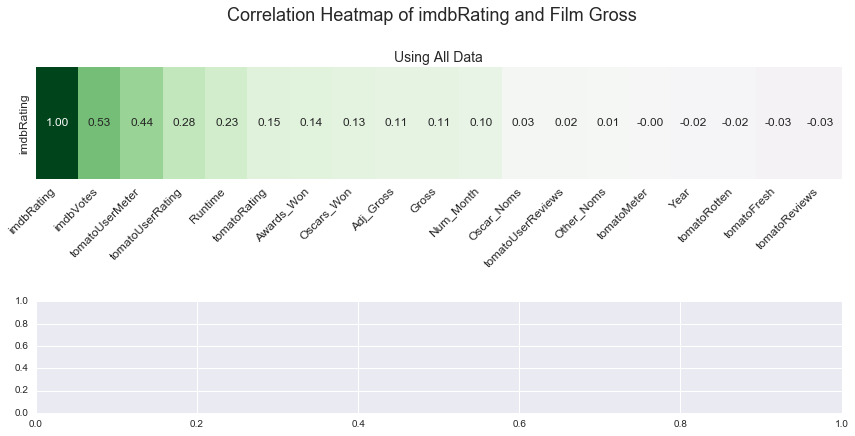

In [445]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=.1, right=None, top=.9, wspace=None, hspace=1.1)
plt.suptitle('Correlation Heatmap of imdbRating and Film Gross', y=1.04, fontsize=18)

gross_corr = df.corr().ix[['imdbRating']].sort_values('imdbRating', \
                                                       axis=1, ascending=False)
sns.heatmap(gross_corr, cmap='PRGn', annot=True, annot_kws={'size': 12}, \
                fmt='.2f', ax=ax1, cbar=False)
ax1.set_title('Using All Data', fontsize=14, y=1.01)
ax1.set_xticklabels(gross_corr.columns, rotation=45, horizontalalignment='right')
ax1.tick_params(axis='both', labelsize=12 )

# gross_co = lm_test.corr().ix[['imdbRating']].sort_values('imdbRating', \
#                                                              axis=1, ascending=False)
# sns.heatmap(rating_corr2, cmap='BrBG', annot=True, annot_kws={'size': 12}, \
#                 fmt='.2f', ax=ax2, cbar=False)
# ax2.set_title('Using Data Where Gross is Not Null', fontsize=14, y=1.01)
# ax2.set_xticklabels(rating_corr.columns, rotation=45, horizontalalignment='right')
# ax2.tick_params(axis='both', labelsize=12 )

# plt.savefig('lm_test_imdb_rating_heatmap.png')

## Count Vectorization

In [ ]:
# Actor, Director, Plot, Title, Genre, Production

In [446]:
# CountVectorizer w/parameters
cvec = CountVectorizer(stop_words='english', lowercase=True, \
                      max_features=25, binary=True)

"""I chose to limit max features to 25 because:
1. Avoid overfitting: In a dataset with only 250 rows, 
I don't want to blow up features (curse of dimensionality?) 
2. Operational efficiency: Processing time too slow with too many features)"""

"I chose to limit max features to 25 because:\n1. Avoid overfitting: In a dataset with only 250 rows, \nI don't want to blow up features (curse of dimensionality?) \n2. Operational efficiency: Processing time too slow with too many features)"

#### Language

#### Actors

In [448]:
# Create column of first names only
df['Actor_First_Name'] = df['Actors'].apply(lambda x: x.split(',')[0])
df['Actor_First_Name'] = df['Actors'].apply(lambda x: x.split(' ')[0])
print df['Actor_First_Name'].head(3)

# Create column of lead actors only
df['Lead_Actor'] = df['Actors'].apply(lambda x: x.split(',')[0])
print df['Lead_Actor'].head(3)

# Create column of concatenated names to identify unique people
df['Actors'] = df['Actors'].apply(lambda x: x.replace(' ',''))
print df['Actors'].head(3)

0       Miles
1     Toshirô
2    Harrison
Name: Actor_First_Name, dtype: object
0      Miles Teller
1    Toshirô Mifune
2     Harrison Ford
Name: Lead_Actor, dtype: object
0    MilesTeller,J.K.Simmons,PaulReiser,MelissaBenoist
1    ToshirôMifune,TakashiShimura,KeikoTsushima,Yuk...
2      HarrisonFord,KarenAllen,PaulFreeman,RonaldLacey
Name: Actors, dtype: object


In [449]:
actors_df.shape

(250, 25)

In [450]:
actors_df = cvec.fit_transform(df['Actors']).todense()
actor_col = cvec.get_feature_names()
actors_df = pd.DataFrame(actors_df, columns=actor_col)

actors = pd.DataFrame(actors_df.sum())
actors.columns = ['Count']
actors.sort_values(['Count'], ascending=False, inplace=True)
actors.head()

,Count
leonardodicaprio,7
robertdeniro,7
harrisonford,7
tomhanks,6
clinteastwood,6


4    9
3    9
7    3
6    2
5    2
Name: Count, dtype: int64
(16, 1)
                  Count
tomhanks              6
clinteastwood         6
leonardodicaprio      7
robertdeniro          7
harrisonford          7


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


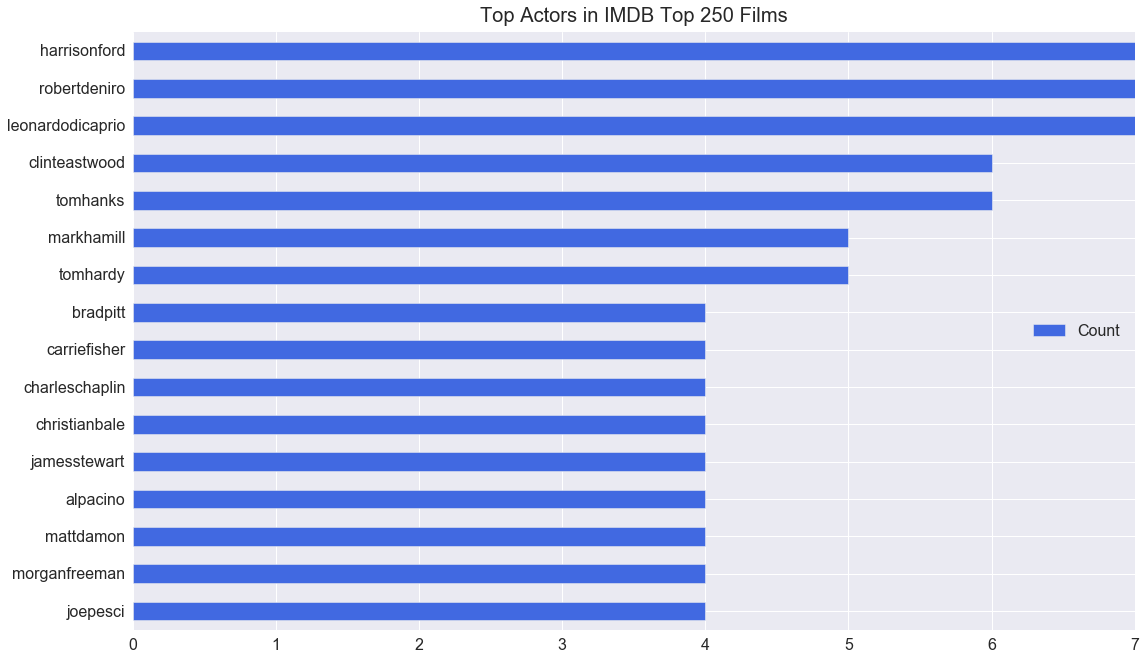

In [451]:
print actors['Count'].value_counts()
top_actors = actors[actors['Count'] > 3]
top_actors.sort_values('Count', ascending=True, inplace=True)
print top_actors.shape
print top_actors.tail()

ax = top_actors.plot(kind='barh', figsize=(16,10), color='royalblue')
ax.set_title('Top Actors in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

          Count
james         4
clint         5
robert        5
leonardo      6
tom           8
3    16
4     4
5     2
8     1
6     1
2     1
Name: Count, dtype: int64


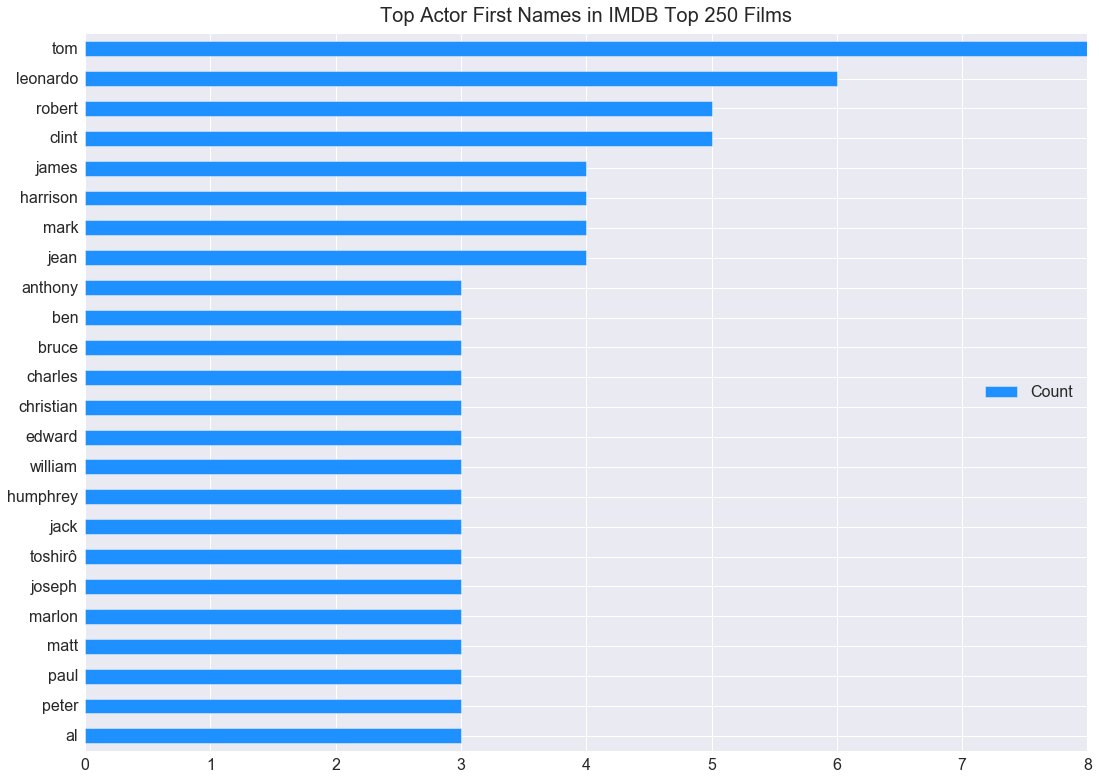

In [452]:
actor_first = cvec.fit_transform(df['Actor_First_Name']).todense()
actor_first_col = cvec.get_feature_names()
actor_first = pd.DataFrame(actor_first, columns=actor_first_col)

actor_first = pd.DataFrame(actor_first.sum())
actor_first.columns = ['Count']
actor_first.sort_values(['Count'], inplace=True)
print actor_first.tail()
print actor_first['Count'].value_counts()

top_actor_first = actor_first[actor_first['Count'] > 2]

"""self, x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, \
sharey=False, layout=None, figsize=None, use_index=True, title=None, \
grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, \
xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, \
colormap=None, table=False, yerr=None, xerr=None, secondary_y=False, \
sort_columns=False, **kwds"""

ax = top_actor_first.plot(kind='barh', figsize=(16,12), color='dodgerblue')
ax.set_title('Top Actor First Names in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

#### Unused Categorical Histograms

In [ ]:
# Ask how to create barh subplots with categorical histograms

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,30), sharex=True)

ax1.barh( color='royalblue')
ax1.set_title('Top Actors in IMDB Top 250 Films', y=1.01)
ax1.tick_params(labelsize=16)
ax1.legend(fontsize=16, loc='center right')

ax2 = top_actor_first.plot(kind='barh', figsize=(16,12), color='dodgerblue')
ax2.set_title('Top Actor First Names in IMDB Top 250 Films', y=1.01)
ax2.tick_params(labelsize=16)
ax2.legend(fontsize=16, loc='center right')

#### Directors 

3    12
7     5
5     4
6     2
4     2
Name: Count, dtype: int64
(13, 1)
                  Count
stevenspielberg       7
christophernolan      7
martinscorsese        7
alfredhitchcock       7
stanleykubrick        7


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


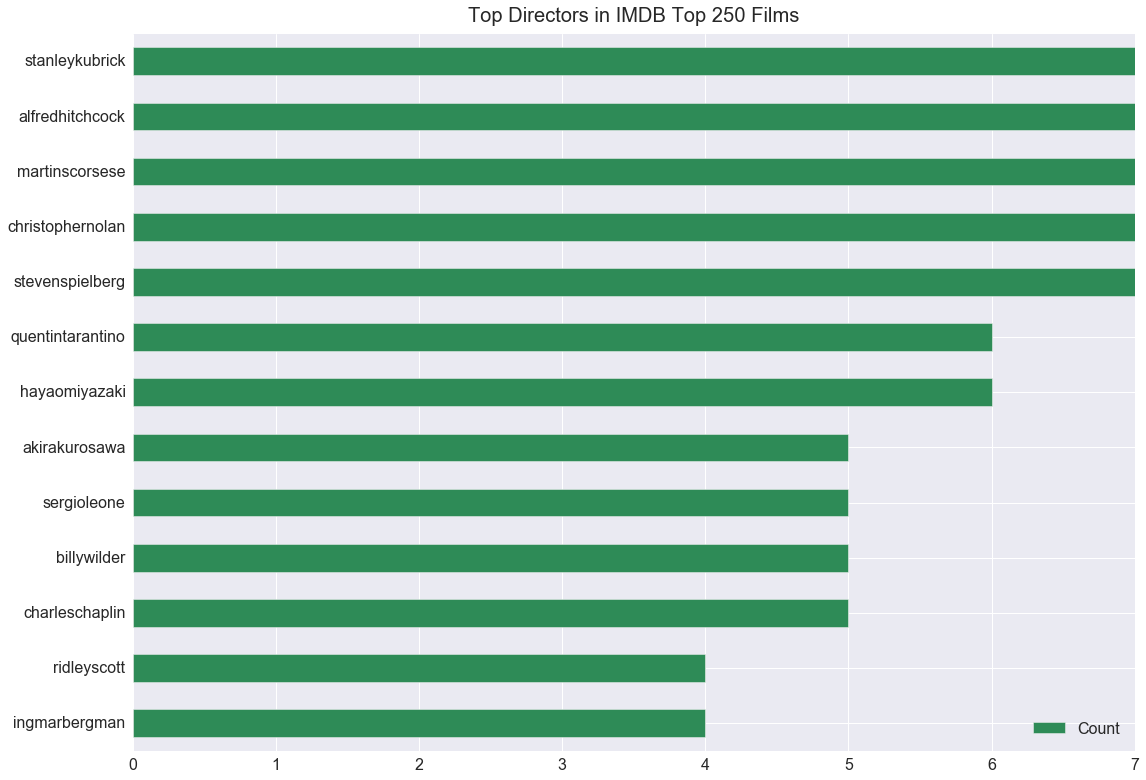

In [453]:
# Create column of concatenated directors to identify unique people
df['Director'] = df['Director'].apply(lambda x: x.replace(' ',''))

directors_df = cvec.fit_transform(df['Director']).todense()
directors_col = cvec.get_feature_names()
directors_df = pd.DataFrame(directors_df, columns=directors_col)
directors = pd.DataFrame(directors_df.sum())
directors.columns = ['Count']
directors.sort_values(['Count'], inplace=True)

print directors['Count'].value_counts()
top_directors = directors[directors['Count'] > 3]
top_directors.sort_values('Count', inplace=True)
print top_directors.shape
print top_directors.tail()

ax = top_directors.plot(kind='barh', figsize=(16,12), color='seagreen')
ax.set_title('Top Directors in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='lower right')

#### Plot

(25, 1)
        Count
story      23
father     24
time       25
police     26
war        28
new        31
man        36
young      39
world      40
life       49


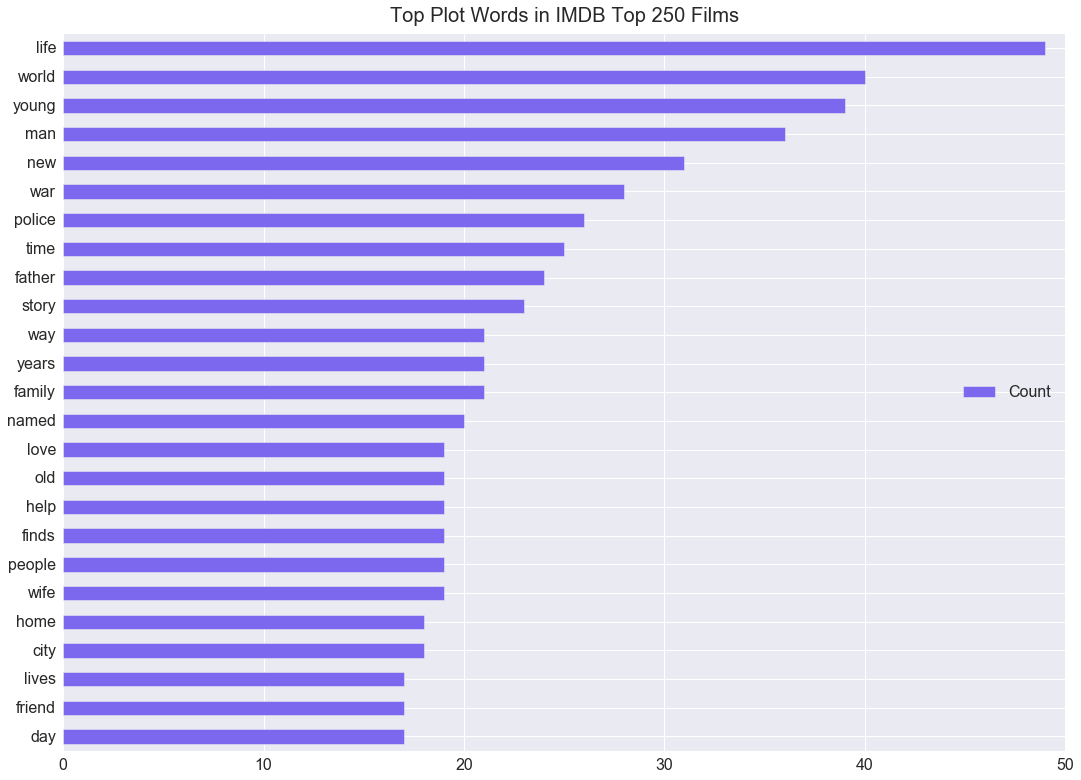

In [454]:
plot_df = cvec.fit_transform(df['Plot']).todense()
plot_col = cvec.get_feature_names()
plot_df = pd.DataFrame(plot_df, columns=plot_col)
plot = pd.DataFrame(plot_df.sum())
plot.columns = ['Count']
plot.sort_values(['Count'], inplace=True)
plot['Count'].value_counts().sort_values(ascending=True)

# print plot['Count'].value_counts()
top_plot = plot[plot['Count'] > 15]
top_plot.sort_values('Count', inplace=True)
print top_plot.shape
print top_plot.tail(10)

ax = top_plot.plot(kind='barh', figsize=(16,12), color='mediumslateblue')
ax.set_title('Top Plot Words in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

#### Title

(25, 1)
         Count
city         3
day          3
episode      3
man          3
rings        3
lord         3
life         3
story        3
wars         4
star         4


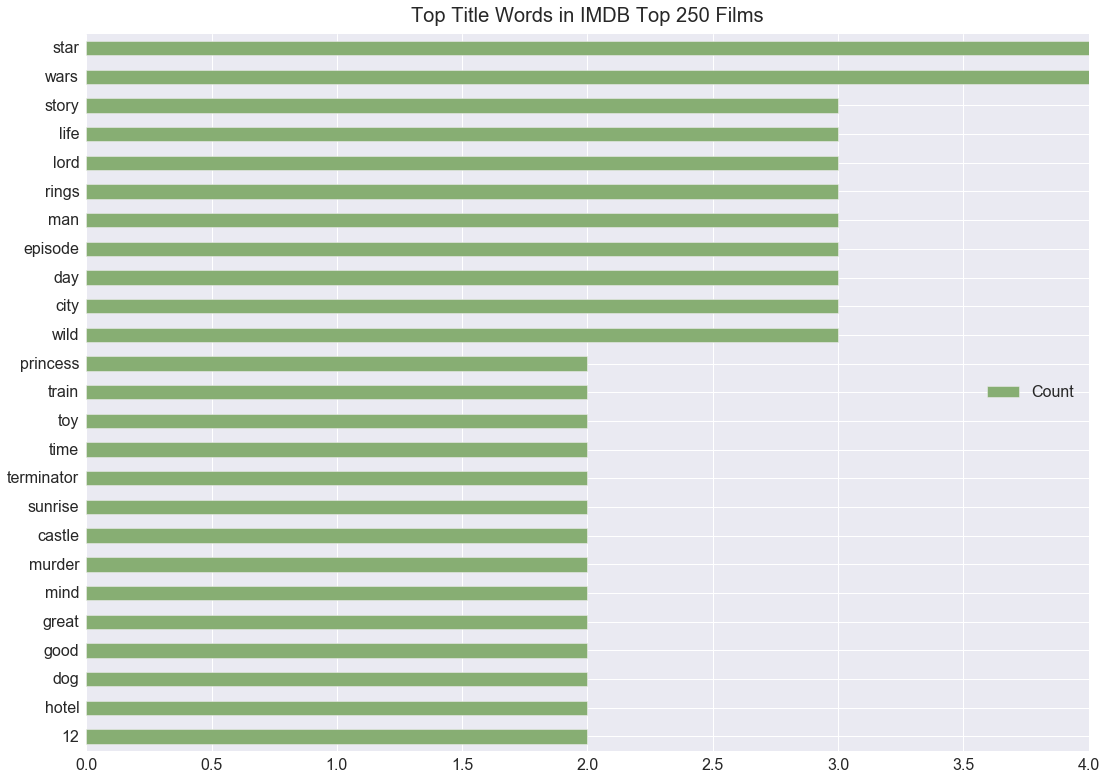

In [455]:
title_df = cvec.fit_transform(df['Title']).todense()
title_col = cvec.get_feature_names()
title_df = pd.DataFrame(title_df, columns=title_col)
title = pd.DataFrame(title_df.sum())
title.columns = ['Count']
title.sort_values(['Count'], inplace=True)
title['Count'].value_counts().sort_values(ascending=True)

# print plot['Count'].value_counts()
top_title = title[title['Count'] > 1]
top_title.sort_values('Count', inplace=True)
print top_title.shape
print top_title.tail(10)

ax = top_title.plot(kind='barh', figsize=(16,12), color='sage')
ax.set_title('Top Title Words in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

#### Genre

(23, 1)
           Count
sci           22
fantasy       23
biography     25
mystery       30
action        35
thriller      41
comedy        43
crime         57
adventure     61
drama        172


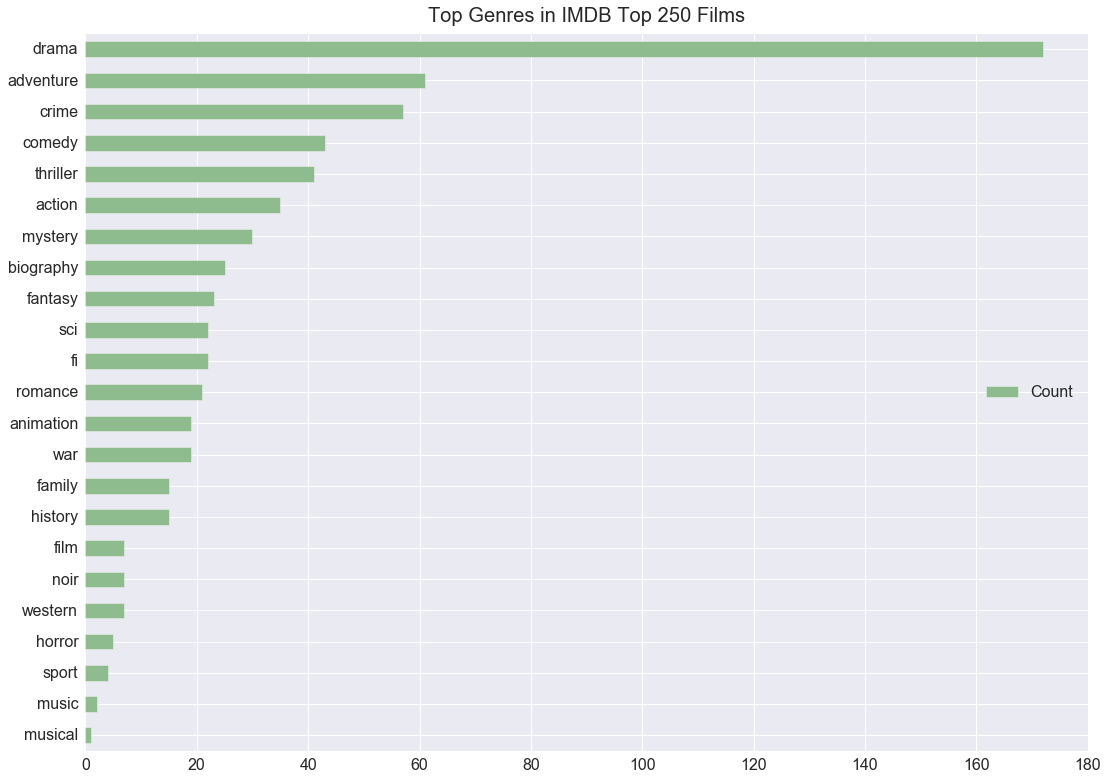

In [456]:
genre_df = cvec.fit_transform(df['Genre']).todense()
genre_col = cvec.get_feature_names()
genre_df = pd.DataFrame(genre_df, columns=genre_col)
genre = pd.DataFrame(genre_df.sum())
genre.columns = ['Count']
genre.sort_values(['Count'], inplace=True)
genre['Count'].value_counts().sort_values(ascending=True)

# print plot['Count'].value_counts()
top_genre = genre[genre['Count'] > 0]
top_genre.sort_values('Count', inplace=True)
print top_genre.shape
print top_genre.tail(10)

ax = top_genre.plot(kind='barh', figsize=(16,12), color='darkseagreen')
ax.set_title('Top Genres in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

#### Production Company

0    SonyPicturesClassics
1        ColumbiaPictures
2       ParamountPictures
Name: Production, dtype: object
(19, 1)
                      Count
sonypicturesclassics      6
waltdisneypictures        7
columbiapictures         10
miramaxfilms             10
20thcenturyfox           11
universalpictures        12
unitedartists            13
paramountpictures        18
pictures                 20
warnerbros               29


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


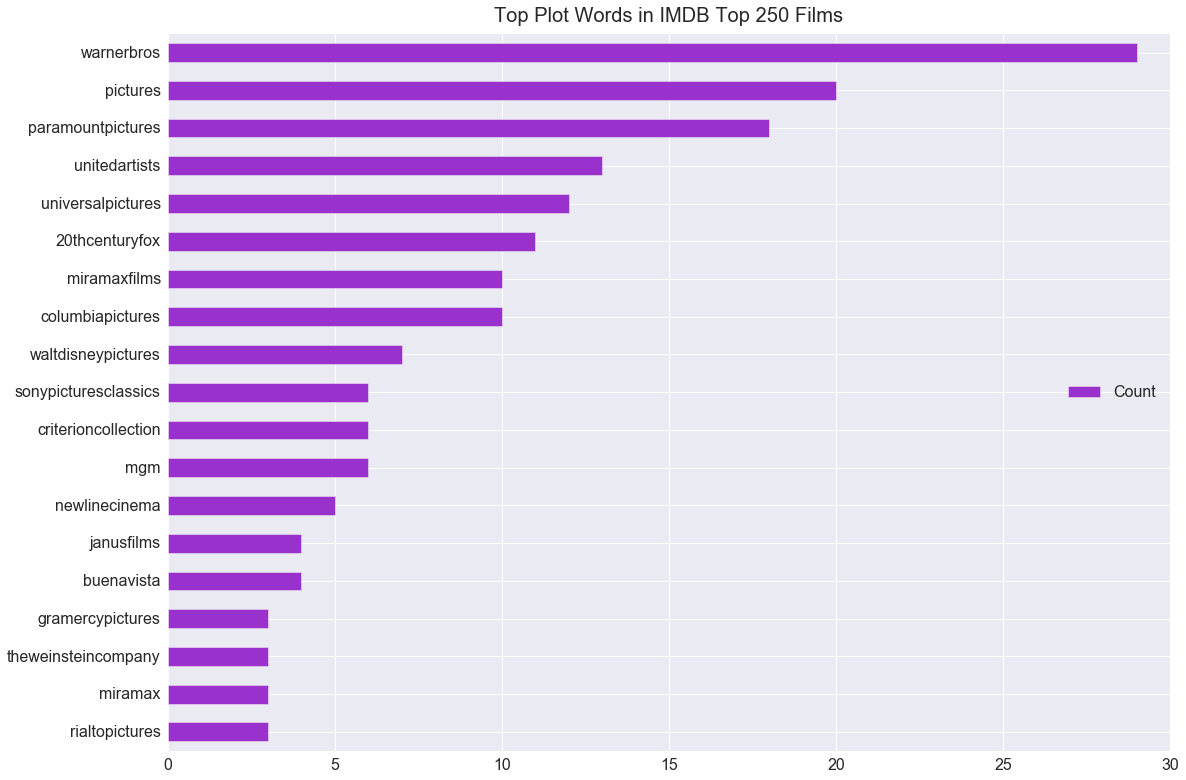

In [457]:
# Create column of concatenated production company names to identify unique companies
df['Production'] = df['Production'].apply(lambda x: x.replace(' ',''))
print df['Production'].head(3)

production_df = cvec.fit_transform(df['Production']).todense()
production_col = cvec.get_feature_names()
production_df = pd.DataFrame(production_df, columns=production_col)
production = pd.DataFrame(production_df.sum())
production.columns = ['Count']
production.sort_values(['Count'], inplace=True)
production['Count'].value_counts().sort_values(ascending=True)

# print production['Count'].value_counts()
top_production = production[production['Count'] > 2]
top_production.sort_values('Count', inplace=True)
print top_production.shape
print top_production.tail(10)

ax = top_production.plot(kind='barh', figsize=(16,12), color='darkorchid')
ax.set_title('Top Plot Words in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

### New dataframes for limited top categorical columns

In [458]:
print top_actors.shape
print top_directors.shape
print top_plot.shape
print top_title.shape
print top_genre.shape
print top_production.shape

(16, 1)
(13, 1)
(25, 1)
(25, 1)
(23, 1)
(19, 1)


## EDA

### Histograms

#### Year, Runtime, Gross

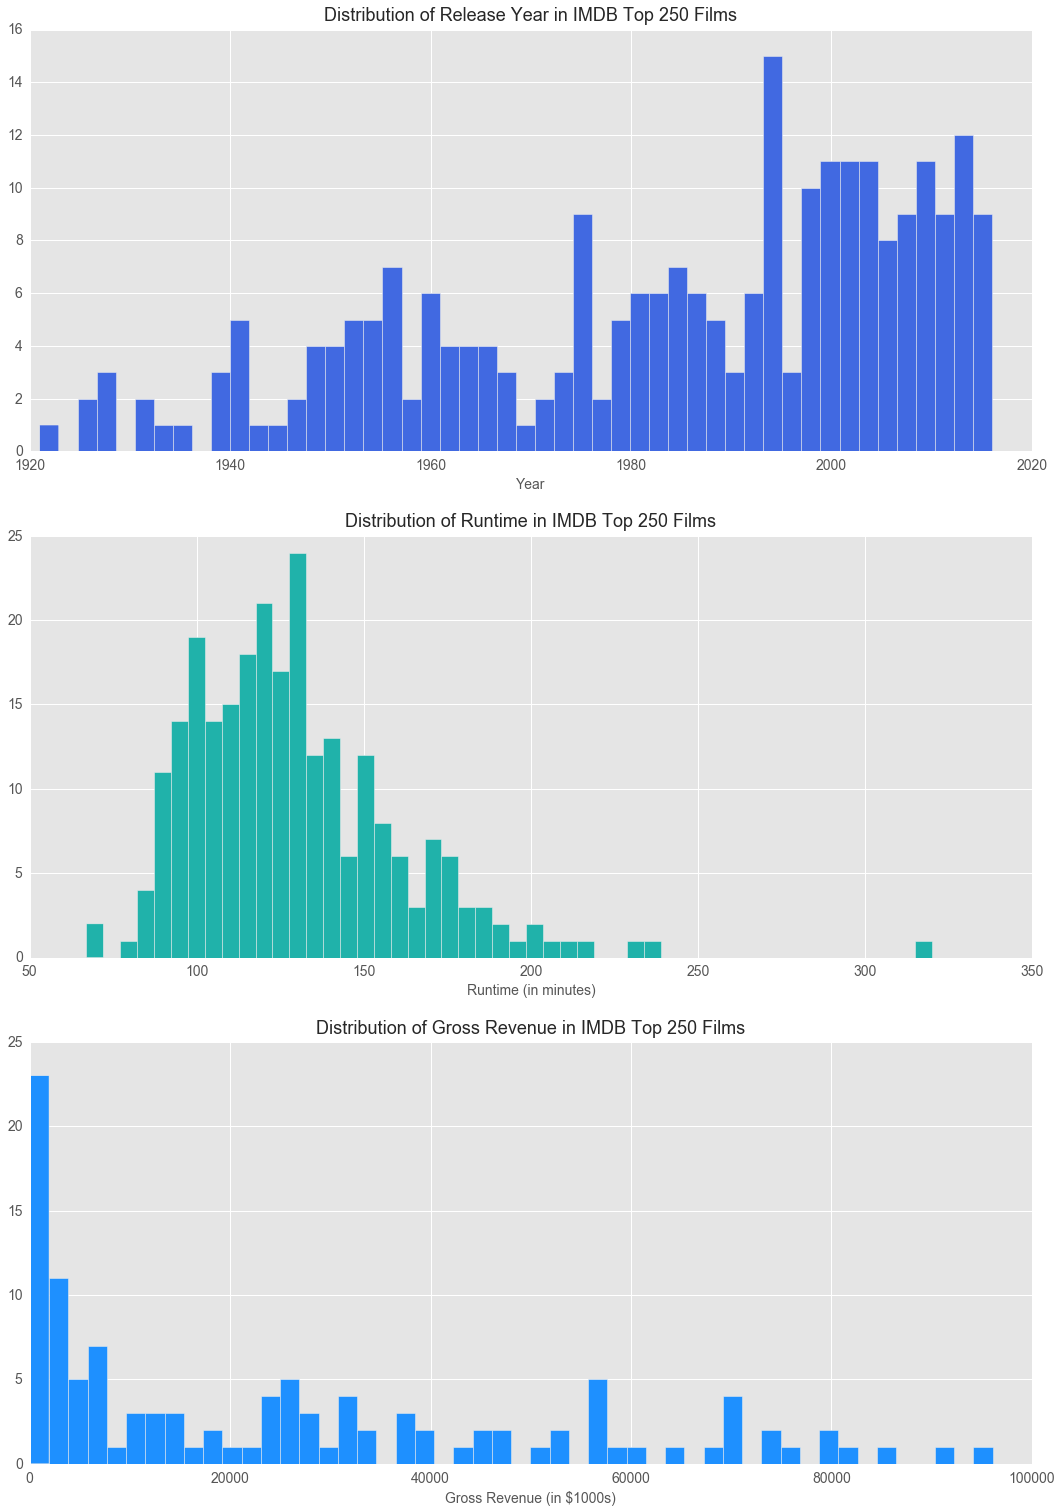

In [459]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(16,24))

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

ax1.hist(df['Year'], bins=50, color='royalblue')
ax1.set_title('Distribution of Release Year in IMDB Top 250 Films', \
             fontsize=18, y=1.01)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylim(top=16)
ax1.tick_params(labelsize=14)

ax2.hist(df['Runtime'], bins=50, color='lightseagreen')
ax2.set_title('Distribution of Runtime in IMDB Top 250 Films', \
             fontsize=18, y=1.01)
ax2.set_xlabel('Runtime (in minutes)', fontsize=14)
ax2.tick_params(labelsize=14)

gross_hist = df[df['Gross'] < 100000000]
gross_hist = gross_hist[gross_hist['Gross'] > 0]
ax3.hist(gross_hist['Gross']/1000, bins=50, color='dodgerblue')
ax3.set_title('Distribution of Gross Revenue in IMDB Top 250 Films', \
             fontsize=18, y=1.01)
ax3.set_xlabel('Gross Revenue (in $1000s)', fontsize=14, y = -2.01)
ax3.tick_params(labelsize=14)

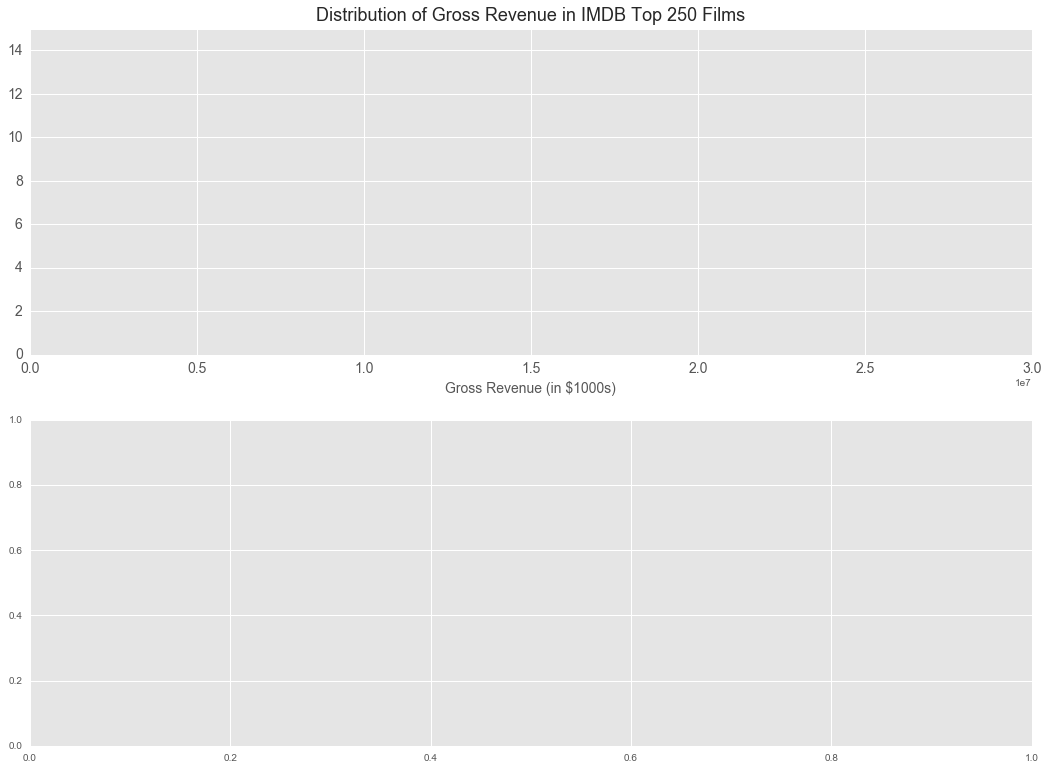

In [461]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)


gross_hist = df[df['Gross'] < 5000000]
gross_hist = gross_hist[gross_hist['Gross'] > 0]
ax1.hist(gross_hist['Gross']/1000, bins=25, color='dodgerblue')
ax1.set_title('Distribution of Gross Revenue in IMDB Top 250 Films', \
             fontsize=18, y=1.01)
ax1.set_xlabel('Gross Revenue (in $1000s)', fontsize=14, y = -2.01)
ax1.set_ylim(top=15)
ax1.tick_params(labelsize=14)
ax1.axvline(x=((gross_median*corr_index)),ymin=0,ymax=None,\
            c="red",linewidth=5,zorder=0)


#### Reviews

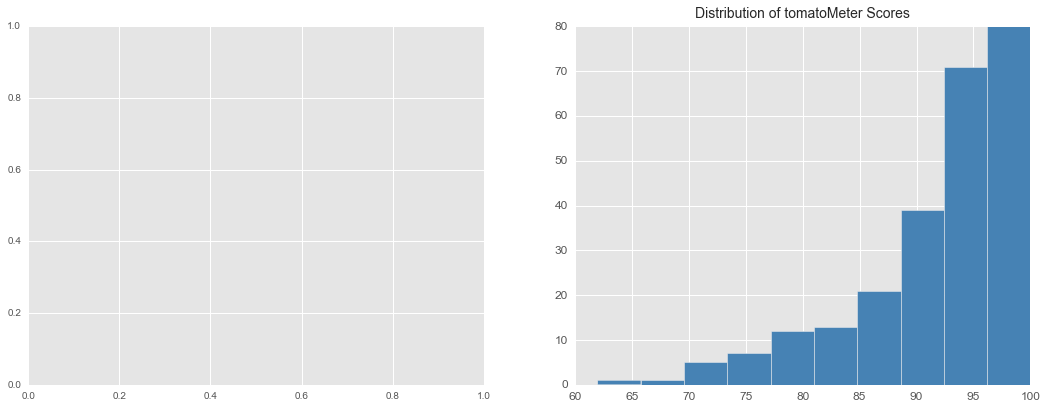

In [462]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(16,6))

# metascore = df[df['Metascore'] > 0]
# ax1.hist(metascore['Metascore'], color='royalblue')
# ax1.set_title('Distribution of Metascores', \
#              fontsize=14, y=1.01)
# ax1.tick_params(labelsize=12)

tomatoMeter = df[df['tomatoMeter'] > 0]
ax2.hist(tomatoMeter['tomatoMeter'], color='steelblue')
ax2.set_title('Distribution of tomatoMeter Scores', \
             fontsize=14, y=1.01)
ax2.tick_params(labelsize=12)

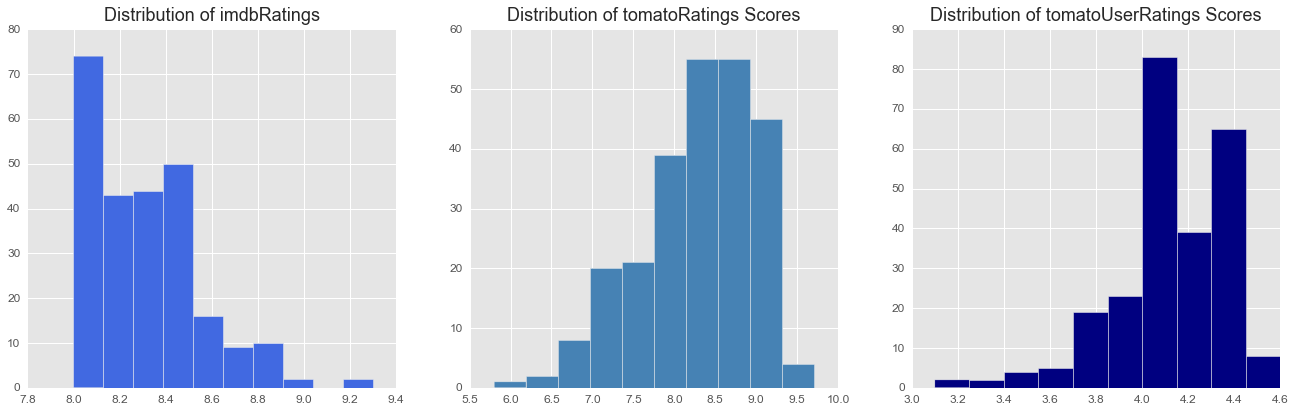

In [463]:
plt.style.use('ggplot')
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(20,6))

imdbRating = df[df['imdbRating'] > 0]
ax1.hist(df['imdbRating'], color='royalblue')
ax1.set_title('Distribution of imdbRatings', \
             fontsize=18, y=1.01)
ax1.tick_params(labelsize=12)

tomatoRating = df[df['tomatoRating'] > 0]
ax2.hist(tomatoMeter['tomatoRating'], color='steelblue')
ax2.set_title('Distribution of tomatoRatings Scores', \
             fontsize=18, y=1.01)
ax2.tick_params(labelsize=12)

tomatoRating = df[df['tomatoRating'] > 0]
ax2.hist(tomatoMeter['tomatoRating'], color='steelblue')
ax2.set_title('Distribution of tomatoRatings Scores', \
             fontsize=18, y=1.01)


tomatoUserRating = df[df['tomatoUserRating'] > 0]
ax3.hist(tomatoMeter['tomatoUserRating'], color='navy')
ax3.set_title('Distribution of tomatoUserRatings Scores', \
             fontsize=18, y=1.01)
ax3.tick_params(labelsize=12)

### Scatterplots

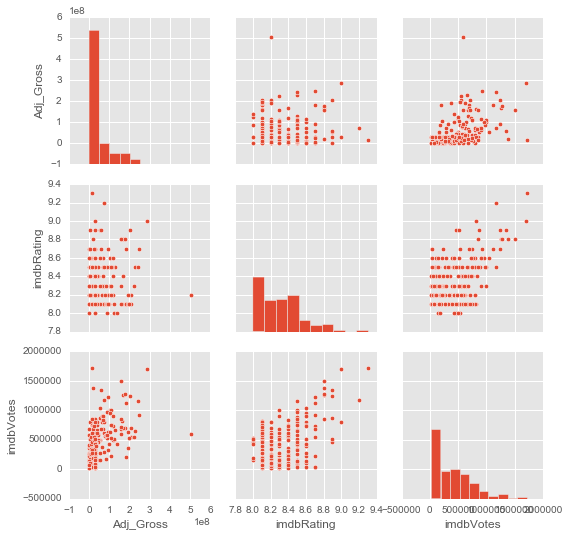

In [464]:
pairplot_cols = ['Adj_Gross', 'imdbRating', 'imdbVotes']
pairplot_df = df.loc[:, pairplot_cols]
sns.pairplot(pairplot_df)
# Not much of a relationship between target and gross (as I would've guessed)

### Unused Separate Histograms

In [ ]:
bins_dict = {'Year': 50, 'Runtime': 50, 'imdbRating': 50}
facecolor_dict = {'Year': 'royalblue', 'Runtime': 'coral', 'imdbRating': 'lightseagreen'}
axis_titles = {'Year': 'Distribution of Years in IMDB Top 250 Films',
              'Runtime': 'Distribution of Runtime in IMDB Top 250 Films',
              'imdbRating': 'Distribution of Years in IMDB Top 250 Films'}
#data, column=None, by=None, grid=True, xlabelsize=None, 
#xrot=None, ylabelsize=None, yrot=None, ax=None, sharex=False, 
#sharey=False, figsize=None, layout=None, bins=10, **kwds)¶
xlabel = 14
ylabel = 14
year_bins = 50
df['Year'].hist(figsize=(16,4),xlabelsize=xlabel, ylabelsize=ylabel, bins=bins_dict['Year'],
               facecolor=facecolor_dict['Year'], alpha = .85)

In [ ]:
bins_dict = {'Year': 50, 'Runtime': 50, 'imdbRating': 50}
facecolor_dict = {'Year': 'royalblue', 'Runtime': 'coral', 'imdbRating': 'lightseagreen'}
axis_titles = {'Year': 'Distribution of Years in IMDB Top 250 Films',
              'Runtime': 'Distribution of Runtime in IMDB Top 250 Films',
              'imdbRating': 'Distribution of Years in IMDB Top 250 Films'}


def hist_plot(x):
    fig = plt.figure(figsize=(16,6))
    ax = fig.add_subplot(111)
    n, bins, patches = ax.hist(x,  bins=bins_dict[x], facecolor=facecolor_dict[x], alpha=0.85)
    ax.set_title(axis_titles[x], fontsize=20, y=1.02)
    #ax.set_xticklabels(labels, fontsize=16)
    #ax.set_xticks(labels)
    #ax.set_ylim(0, 16)
    #y_labels = [i for i in range(18) if i%2 == 0]
    #ax.set_yticklabels(y_labels, fontsize=16)

In [ ]:
# Years
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(df['Year'],  bins=50, facecolor='royalblue', alpha=0.85)

def decades():
    i = 1910
    labels = []
    while i < 2020:
        labels.append(i + 10)
        i += 10
    return labels
labels = decades()

ax.set_title('Distribution of Years in IMDB Top 250 Films', fontsize=20, y=1.02)
ax.set_xticklabels(labels, fontsize=16)
ax.set_xticks(labels)
ax.set_ylim(0, 16)
y_labels = [i for i in range(18) if i%2 == 0]
ax.set_yticklabels(y_labels, fontsize=16)

In [ ]:
# Runtime
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(df['Runtime'],  bins=50, facecolor='coral', alpha=0.85)

ax.set_title('Distribution of Runtime in IMDB Top 250 Films', fontsize=20, y=1.02)

## Standardizing and Dummies

### Use StandardScaler to standardize numerical data

In [465]:
# Isolate numeric columns for standardizing
number_cols = [i for i in df.columns if df[i].dtype == 'float64' \
              or df[i].dtype == 'int']
number_cols.remove('Gross')
number_cols

['Year',
 'imdbRating',
 'imdbVotes',
 'tomatoMeter',
 'tomatoRating',
 'tomatoReviews',
 'tomatoUserMeter',
 'tomatoUserRating',
 'tomatoUserReviews',
 'tomatoFresh',
 'tomatoRotten',
 'Runtime',
 'Num_Month',
 'Oscars_Won',
 'Oscar_Noms',
 'Awards_Won',
 'Other_Noms',
 'Adj_Gross']

In [466]:
# Standardize numeric columns
standardscaler = StandardScaler()
df.loc[:, number_cols] = standardscaler.fit_transform(df[number_cols])

In [467]:
df[['imdbRating', 'tomatoRating', 'tomatoUserRating', 'tomatoMeter']].head()

,imdbRating,tomatoRating,tomatoUserRating,tomatoMeter
0,0.770426,0.431387,1.644015,0.267007
1,1.628362,1.432616,1.644015,1.087727
2,0.770426,1.289583,-0.001646,0.267007
3,-0.516477,1.289583,-0.413061,0.267007
4,0.770426,-2.143203,2.055430,-0.416926


### Create dummy variables

In [468]:
# Create dummy variables for rated column
rated = pd.get_dummies(df['Rated'], prefix='Rated')
rated.head(3)

,Rated_G,Rated_OTHER,Rated_PG,Rated_PG-13,Rated_R
0,0,0,0,0,1
1,0,1,0,0,0
2,0,0,1,0,0


In [469]:
# Create dummy variables for genre column
genre = pd.get_dummies(df['Genre_1'], prefix='Genre')
genre.head(3)

,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,Genre_Comedy,Genre_Crime,Genre_Drama,Genre_Film-Noir,Genre_Horror,Genre_Mystery,Genre_Sci-Fi,Genre_Western
0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0


In [470]:
# Create dummy variables for genre column
season = pd.get_dummies(df['Season'], prefix='Season')
season.head(3)

,Season_Fall,Season_Holiday,Season_Summer,Season_Winter
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0


In [471]:
# Create dummy variables for month column
month = pd.get_dummies(df['Month'], prefix='Month')
month.head(3)

,Month_,Month_Apr,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0


### Create a new model_df by concatenating other dataframes together

In [472]:
# list of dataframes:
"""
df
actors_df
directors_df
plot_df
title_df
genre_df
production_df
rated
genre
season
month
"""

'\ndf\nactors_df\ndirectors_df\nplot_df\ntitle_df\ngenre_df\nproduction_df\nrated\ngenre\nseason\nmonth\n'

In [487]:
model_df = df[['Year', 'imdbRating', 'imdbVotes', \
             'tomatoMeter', 'tomatoRating', 'tomatoReviews', \
             'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', \
             'tomatoFresh', 'tomatoRotten', 'Runtime', \
              'Oscars_Won', 'Awards_Won', 'Oscar_Noms', 'Other_Noms', \
             'Adj_Gross']]
model_df.head(2)

,Year,imdbRating,imdbVotes,tomatoMeter,tomatoRating,tomatoReviews,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,tomatoFresh,tomatoRotten,Runtime,Oscars_Won,Awards_Won,Oscar_Noms,Other_Noms,Adj_Gross
0,1.238348,0.770426,0.021401,0.267007,0.431387,1.726447,0.423738,1.644015,-0.239982,1.875724,0.304953,-0.694059,0.728251,1.669233,-0.483864,2.047323,-0.665316
1,-1.242649,1.628362,-0.513134,1.087727,1.432616,-0.638168,1.159394,1.644015,-0.236402,-0.578189,-0.725294,2.432333,-0.651013,-0.581591,0.750482,-0.619018,-0.775033


In [474]:
print 'df', df.shape
print 'actors_df', actors_df.shape
print 'directors_df', directors_df.shape
print 'plot_df', plot_df.shape
print 'title_df', title_df.shape
print 'genre_df', genre_df.shape
print 'production_df', production_df.shape
print 'rated', rated.shape
print 'genre', genre.shape
print 'season', season.shape
print 'month', month.shape

df (250, 37)
actors_df (250, 25)
directors_df (250, 25)
plot_df (250, 25)
title_df (250, 25)
genre_df (250, 23)
production_df (250, 25)
rated (250, 5)
genre (250, 12)
season (250, 4)
month (250, 13)


In [475]:
# model_df = pd.concat([model_df, actors_df, directors_df, plot_df, title_df, \
#                      genre_df, production_df, rated, genre, season], axis=1)
# print model_df.shape
# model_df.head(2)

In [488]:
model_df1 = pd.concat([model_df, actors_df, directors_df, plot_df, title_df,
                      genre_df, production_df, rated, genre, season, month], 
                      axis=1)
print model_df1.shape
model_df1.head(2)

(250, 199)


,Year,imdbRating,imdbVotes,tomatoMeter,tomatoRating,tomatoReviews,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,tomatoFresh,...,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,1.238348,0.770426,0.021401,0.267007,0.431387,1.726447,0.423738,1.644015,-0.239982,1.875724,...,0,0,0,0,0,0,0,0,1,0
1,-1.242649,1.628362,-0.513134,1.087727,1.432616,-0.638168,1.159394,1.644015,-0.236402,-0.578189,...,0,0,0,0,0,0,0,1,0,0


## Regression

### Regressors

#### With imdbVotes

In [717]:
X = model_df1.drop(['imdbRating'], axis=1)
y = model_df1['imdbRating']

cv = KFold(5, random_state=7, shuffle=True)
cv

KFold(n_splits=5, random_state=7, shuffle=True)

In [587]:
### Regressors ###

tree = DecisionTreeRegressor(random_state=7)
bag = BaggingRegressor(random_state=7)
forest = RandomForestRegressor(n_jobs=-1, random_state=7)
ada = AdaBoostRegressor(random_state=7)
extra = ExtraTreesRegressor(n_jobs=-1, random_state=7)
grade = GradientBoostingRegressor(random_state=7, criterion='mse')
reg_model_abbrev = ['tree', 'bag', 'forest', 'extra', 'ada', 'grade']

model_dict = {
    'DecisionTree_Reg': DecisionTreeRegressor(random_state=7),
    'Bagging_Reg': BaggingRegressor(random_state=7),
    'RandomForest_Reg': RandomForestRegressor(n_jobs=-1, random_state=7),
    'ExtraTrees_Reg': ExtraTreesRegressor(n_jobs=-1, random_state=7),
    'AdaBoost_Reg': AdaBoostRegressor(random_state=7),
    'GradientBoost_Reg': GradientBoostingRegressor(random_state=7, criterion='mse')
}

model_list = [
    ['DecisionTree_Reg', DecisionTreeRegressor(random_state=7)],
    ['Bagging_Reg', BaggingRegressor(random_state=7)],
    ['RandomForest_Reg', RandomForestRegressor(n_jobs=-1, random_state=7)],
    ['ExtraTrees_Reg', ExtraTreesRegressor(n_jobs=-1, random_state=7)],
    ['AdaBoost_Reg', AdaBoostRegressor(random_state=7)],
    ['GradientBoost_Reg', GradientBoostingRegressor(criterion='mse', 
                                                          random_state=7)]]

In [497]:
# Return cross_val_score from model
def run_model(regressor):
    score = cross_val_score(regressor, X, y,
                            scoring='neg_mean_squared_error', cv=cv)
    return score

####### Question: why the error below? #######
####### Error #######
# Error when trying to set n_job=-1
# //anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: 
# UserWarning: Multiprocessing-backed parallel loops cannot be nested, 
# setting n_jobs=1 **self._backend_args) 

In [498]:
# Run model and return mean and std of mse and append to model_list
def get_metrics(model_list):
    for i in model_list:
        result = run_model(i[1])
        mean = result.mean()*-1.0
        std = result.std()
        model_metrics_imdbVotes.append([i[0], mean, std])
    return model_metrics_imdbVotes

In [ ]:
model_metrics_imdbVotes = []

In [502]:
get_metrics(model_list)

[['DecisionTree_Reg', 0.59767583593651108, 0.050062494142870922],
 ['Bagging_Reg', 0.32507824253862083, 0.070605519568703701],
 ['RandomForest_Reg', 0.33339565257074222, 0.078058655261201454],
 ['ExtraTrees_Reg', 0.39830089298069488, 0.10636650051632039],
 ['AdaBoost_Reg', 0.33683291332469273, 0.061828845599675074],
 ['GradientBoost_Reg', 0.26873647633620151, 0.065478453037621953]]

#### Without imdbVotes

In [919]:
X = model_df1.drop(['imdbRating', 'imdbVotes', 'rating'], axis=1)
y = model_df1['imdbRating']

cv = KFold(5, random_state=7, shuffle=True)

model_list = [
    ['DecisionTree_Reg', DecisionTreeRegressor(random_state=7)],
    ['Bagging_Reg', BaggingRegressor(random_state=7)],
    ['RandomForest_Reg', RandomForestRegressor(n_jobs=-1, random_state=7)],
    ['ExtraTrees_Reg', ExtraTreesRegressor(n_jobs=-1, random_state=7)],
    ['AdaBoost_Reg', AdaBoostRegressor(random_state=7)],
    ['GradientBoost_Reg', GradientBoostingRegressor(criterion='mse', 
                                                          random_state=7)]]

def run_model(regressor):
    score = cross_val_score(regressor, X, y,
                            scoring='neg_mean_squared_error', cv=cv)
    return score

def get_metrics(model_list):
    for i in model_list:
        result = run_model(i[1])
        mean = result.mean()*-1.0
        std = result.std()
        model_metrics.append([i[0], mean, std])
    return model_metrics

In [722]:
model_metrics = []

In [723]:
get_metrics(model_list)

[['DecisionTree_Reg', 0.73826214709891747, 0.16659228726843936],
 ['Bagging_Reg', 0.50692037956831926, 0.085938184692737493],
 ['RandomForest_Reg', 0.4968438005117049, 0.090616524753867042],
 ['ExtraTrees_Reg', 0.56601079349563832, 0.091368935952512678],
 ['AdaBoost_Reg', 0.44444552434627632, 0.063834230889346963],
 ['GradientBoost_Reg', 0.42373233354350565, 0.094961499549693573]]

In [724]:
a = [i[1] for i in model_metrics]
np.mean(a)

0.52936916309406024

In [545]:
# feature_models = [
#     ['DecisionTree_Reg', DecisionTreeRegressor(random_state=7)],
#     ['RandomForest_Reg', RandomForestRegressor(n_jobs=-1, random_state=7)],
#     ['ExtraTrees_Reg', ExtraTreesRegressor(n_jobs=-1, random_state=7)],
#     ['AdaBoost_Reg', AdaBoostRegressor(random_state=7)],
#     ['GradientBoost_Reg', GradientBoostingRegressor(criterion='mse', 
#                                                           random_state=7)]]

In [ ]:
def get_feature_importance(model):
    model.fit(X,y)
    model_features = pd.DataFrame(model.feature_importances_,
                                 index=X.columns, columns=[str(model)[:12]])
    model_features.sort_values(str(model)[:12], ascending=False, inplace=True)
    top_features = model_features.iloc[:16, :]
    return top_features

In [726]:
reg_model_abbrev

['tree', 'bag', 'forest', 'extra', 'ada', 'grade']

In [727]:
tree_features = get_feature_importance(tree)
forest_features = get_feature_importance(forest)
extra_features = get_feature_importance(extra)
ada_features = get_feature_importance(ada)
grade_features = get_feature_importance(grade)

In [917]:
reg_features_df = pd.concat([tree_features, forest_features, extra_features, 
                            ada_features, grade_features], axis=1)
reg_features_df.sort_values('DecisionTree', ascending=False).head(10)

,DecisionTree,RandomForest,ExtraTreesRe,AdaBoostRegr,GradientBoos
tomatoUserMeter,0.455333,0.457380,0.296211,0.405478,0.116557
tomatoUserReviews,0.083229,0.109412,0.044671,0.133985,0.139887
tomatoReviews,0.072662,0.023612,0.021191,0.019498,0.065023
Adj_Gross,0.069110,0.014624,NaN,0.045879,0.025567
christophernolan,0.044573,0.041326,0.050928,0.015002,NaN
tomatoRating,0.037676,0.016309,0.012068,0.016811,0.043855
Year,0.033598,0.019234,NaN,0.034367,0.020712
action,0.015948,NaN,NaN,NaN,NaN
Runtime,0.015489,0.034157,NaN,0.058048,0.061173
tomatoMeter,0.015259,0.011481,NaN,0.040182,0.037564


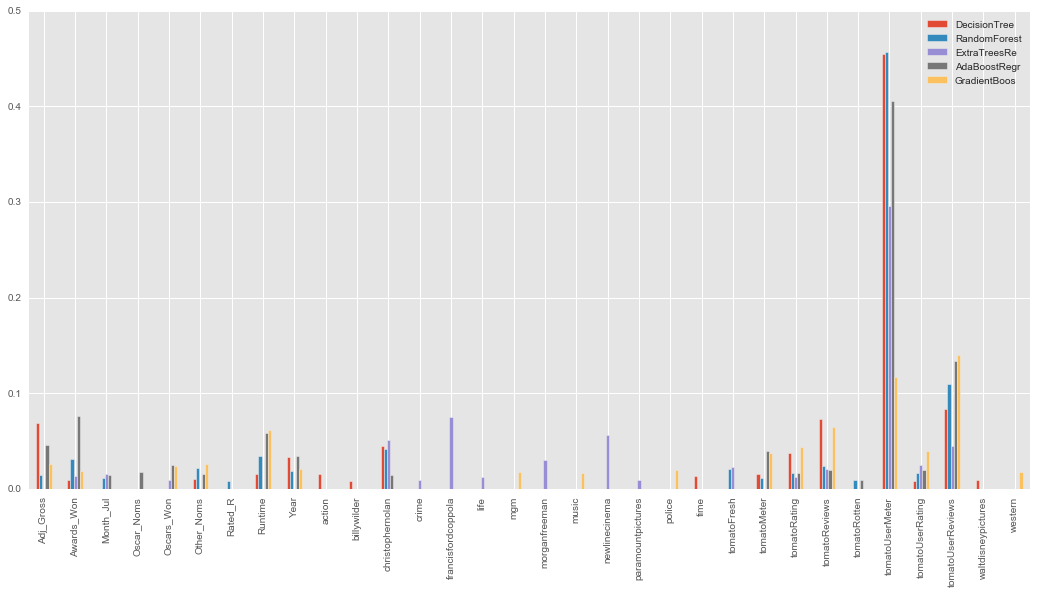

In [916]:
fig, ax = plt.subplots(figsize=(16,8))
reg_features_df.plot(kind='bar', ax=ax)

### Bagging + Regressors

In [632]:
bagging_model_list = [
    ['DecisionTree_Reg_BAGGING', DecisionTreeRegressor(random_state=7)],
    ['RandomForest_Reg_BAGGING', RandomForestRegressor(n_jobs=-1, random_state=7)],
    ['ExtraTrees_Reg_BAGGING', ExtraTreesRegressor(n_jobs=-1, random_state=7)],
    ['AdaBoost_Reg_BAGGING', AdaBoostRegressor(random_state=7)],
    ['GradientBoost_Reg_BAGGING', GradientBoostingRegressor(criterion='mse', 
                                                          random_state=7)]]
bag_tree = DecisionTreeRegressor(random_state=7)
bag_forest = RandomForestRegressor(n_jobs=-1, random_state=7)
bag_ada = AdaBoostRegressor(random_state=7)
bag_extra = ExtraTreesRegressor(n_jobs=-1, random_state=7)
bag_grade = GradientBoostingRegressor(random_state=7, criterion='mse')
bag_reg_model_abbrev = ['bag_' + i for i in reg_model_abbrev]
bag_reg_model_abbrev.remove('bag_bag')
bag_reg_model_abbrev

['bag_tree', 'bag_forest', 'bag_extra', 'bag_ada', 'bag_grade']

In [619]:
bagging_metrics = []

In [620]:
def get_bagging_metrics(model_list):
    for i in model_list:
        result = run_model(BaggingRegressor(i[1], random_state=7))
        mean = result.mean()*-1.0
        std = result.std()
        bagging_metrics.append([i[0], mean, std])
    return bagging_metrics

get_bagging_metrics(bagging_model_list)

[['DecisionTree_Reg_BAGGING', 0.50692037956831926, 0.085938184692737493],
 ['RandomForest_Reg_BAGGING', 0.4784423772777191, 0.10480770127863036],
 ['ExtraTrees_Reg_BAGGING', 0.50370073222650458, 0.075608283502179227],
 ['AdaBoost_Reg_BAGGING', 0.48612159239162356, 0.079357073370453945],
 ['GradientBoost_Reg_BAGGING', 0.42523336887552493, 0.091214274370080034]]

In [628]:
a = [i[1] for i in bagging_metrics]
np.mean(a)

0.48008369006793827

In [923]:
get_feature_importance(bag_tree)
bag_tree_features.head()

,DecisionTree
tomatoUserMeter,0.455333
tomatoUserReviews,0.083229
tomatoReviews,0.072662
Adj_Gross,0.069110
christophernolan,0.044573


### GridSearch Regressors

In [729]:
def run_model(regressor):
    score = cross_val_score(regressor, X, y,
                            scoring='neg_mean_squared_error', cv=cv)
    return score

In [730]:
GS_model_list = [
    ['DecisionTree_GS', DecisionTreeRegressor(random_state=7)],
    ['RandomForest_GS', RandomForestRegressor(n_jobs=-1, random_state=7)],
    ['GradientBoost_GS', GradientBoostingRegressor(criterion='mse', 
                                                          random_state=7)]]

In [ ]:
def get_feature_importance_GS(model):
    #model.fit(X,y)
    best_model = model.best_estimator_
    model_features = pd.DataFrame(best_model.feature_importances_,
                                 index=X.columns, columns=[str(best_model)[:12]])
    model_features.sort_values(str(best_model)[:12], ascending=False, inplace=True)
    top_features = model_features.iloc[:11, :]
    return top_features

In [757]:
GS_metrics = []

#### DecisionTree GridSearch

In [758]:
# DecisionTree GridSearch
parameters = {'max_features':[3,4,5,6], 'max_leaf_nodes':[9,10,11,12], 
              'min_samples_split':[2,3,4], 'max_depth':[5,6,7,8,9], 
              'min_samples_leaf':[1,2,3,4]}
scoring = 'neg_mean_squared_error'

GS_dt = GridSearchCV(GS_model_list[0][1], param_grid=parameters, scoring=scoring, cv=5, 
                 verbose=True, n_jobs=-1)
GS_dt.fit(X,y)
print 'GS_dt best params: ', GS_dt.best_params_
print 'GS_dt best score: ', GS_dt.best_score_

result = run_model(GS_dt.best_estimator_)
mean = result.mean()*-1.0
std = result.std()
GS_metrics.append([GS_model_list[0][0], mean, std])

GS_tree_features = get_feature_importance_GS(GS_dt)
GS_tree_features.head()

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 2888 tasks      | elapsed:    9.0s


GS_dt best params:  {'max_features': 3, 'max_leaf_nodes': 12, 'min_samples_split': 2, 'max_depth': 7, 'min_samples_leaf': 2}
GS_dt best score:  -0.934958819427


[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:   14.3s finished


,DecisionTree
Awards_Won,0.229436
joelcoen,0.188332
tomatoUserMeter,0.127926
christianbale,0.108359
Genre_Crime,0.106331


In [759]:
GS_metrics

[['DecisionTree_GS', 1.0089566708606341, 0.3570181559145989]]

#### RandomForest GridSearch

In [760]:
# RandomForest GridSearch
parameters = {'max_features':[4,5,6], 'max_leaf_nodes':[28,30], 
              'min_samples_split':[9,10,12], 'max_depth':[30,32, 35], 
              'min_samples_leaf':[1]}
scoring = 'neg_mean_squared_error'

GS_forest = GridSearchCV(GS_model_list[1][1], param_grid=parameters, scoring=scoring, cv=5, 
                 verbose=True, n_jobs=-1)
GS_forest.fit(X,y)
print 'GS_forest best params: ', GS_forest.best_params_
print 'GS_forest best score :', GS_forest.best_score_

result = run_model(GS_forest.best_estimator_)
mean = result.mean()*-1.0
std = result.std()
GS_metrics.append([GS_model_list[1][0], mean, std])

GS_forest_features = get_feature_importance_GS(GS_forest)
GS_forest_features.head()

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   21.4s finished


GS_forest best params:  {'max_features': 5, 'max_leaf_nodes': 30, 'min_samples_split': 12, 'max_depth': 30, 'min_samples_leaf': 1}
GS_forest best score : -0.729543919053


,RandomForest
tomatoUserMeter,0.197810
tomatoUserRating,0.037630
columbiapictures,0.036836
tomatoFresh,0.032586
tomatoReviews,0.031525


In [761]:
GS_metrics

[['DecisionTree_GS', 1.0089566708606341, 0.3570181559145989],
 ['RandomForest_GS', 0.77585399488831286, 0.17090941901899676]]

#### GradientBoosting GridSearch

In [762]:
# RandomForest GridSearch
parameters = {'n_estimators':[1600,1800],
              'max_features':[25,35], 'max_leaf_nodes':[4,5], 
              'min_samples_split':[1], 'max_depth':[4,5], 
              'min_samples_leaf':[2]}
scoring = 'neg_mean_squared_error'

GS_gb = GridSearchCV(GS_model_list[2][1], param_grid=parameters, scoring=scoring, cv=5, 
                 verbose=True, n_jobs=-1)
GS_gb.fit(X,y)
print 'GS best params: ', GS_gb.best_params_
print 'GS best score: ', GS_gb.best_score_

result = run_model(GS_gb.best_estimator_)
mean = result.mean()*-1.0
std = result.std()
GS_metrics.append([GS_model_list[2][0], mean, std])

GS_grade_features = get_feature_importance_GS(GS_gb)
GS_grade_features.head()

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   16.9s finished


GS best params:  {'max_leaf_nodes': 5, 'min_samples_leaf': 2, 'n_estimators': 1800, 'max_features': 35, 'min_samples_split': 1, 'max_depth': 4}
GS best score:  -0.424469474935


,GradientBoos
tomatoUserReviews,0.071083
Runtime,0.055645
Year,0.054576
Adj_Gross,0.051948
tomatoReviews,0.047125


In [763]:
GS_metrics

[['DecisionTree_GS', 1.0089566708606341, 0.3570181559145989],
 ['RandomForest_GS', 0.77585399488831286, 0.17090941901899676],
 ['GradientBoost_GS', 0.41886636045486431, 0.081076516404270493]]

### Regressor DataFrame

In [764]:
# Combine all regressor metrics lists
# model_metrics, bagging_metrics, GS_metrics
regressor_metrics = []
regressor_metrics.extend(model_metrics)
regressor_metrics.extend(bagging_metrics)
regressor_metrics.extend(GS_metrics)

In [765]:
regressor_metrics

[['DecisionTree_Reg', 0.73826214709891747, 0.16659228726843936],
 ['Bagging_Reg', 0.50692037956831926, 0.085938184692737493],
 ['RandomForest_Reg', 0.4968438005117049, 0.090616524753867042],
 ['ExtraTrees_Reg', 0.56601079349563832, 0.091368935952512678],
 ['AdaBoost_Reg', 0.44444552434627632, 0.063834230889346963],
 ['GradientBoost_Reg', 0.42373233354350565, 0.094961499549693573],
 ['DecisionTree_Reg_BAGGING', 0.50692037956831926, 0.085938184692737493],
 ['RandomForest_Reg_BAGGING', 0.4784423772777191, 0.10480770127863036],
 ['ExtraTrees_Reg_BAGGING', 0.50370073222650458, 0.075608283502179227],
 ['AdaBoost_Reg_BAGGING', 0.48612159239162356, 0.079357073370453945],
 ['GradientBoost_Reg_BAGGING', 0.42523336887552493, 0.091214274370080034],
 ['DecisionTree_GS', 1.0089566708606341, 0.3570181559145989],
 ['RandomForest_GS', 0.77585399488831286, 0.17090941901899676],
 ['GradientBoost_GS', 0.41886636045486431, 0.081076516404270493]]

In [1001]:
reg_df = pd.DataFrame(regressor_metrics, columns=['Model_Name', 
                                                 'Model_Score', 'Model_Score_Std'])
reg_df_short = reg_df.sort_values('Model_Score', ascending=False).ix[[11,12,0,3,6], :]
reg_df_short.head()

,Model_Name,Model_Score,Model_Score_Std
11,DecisionTree_GS,1.008957,0.357018
12,RandomForest_GS,0.775854,0.170909
0,DecisionTree_Reg,0.738262,0.166592
3,ExtraTrees_Reg,0.566011,0.091369
6,DecisionTree_Reg_BAGGING,0.506920,0.085938


#### Top Tree Regressors Plot

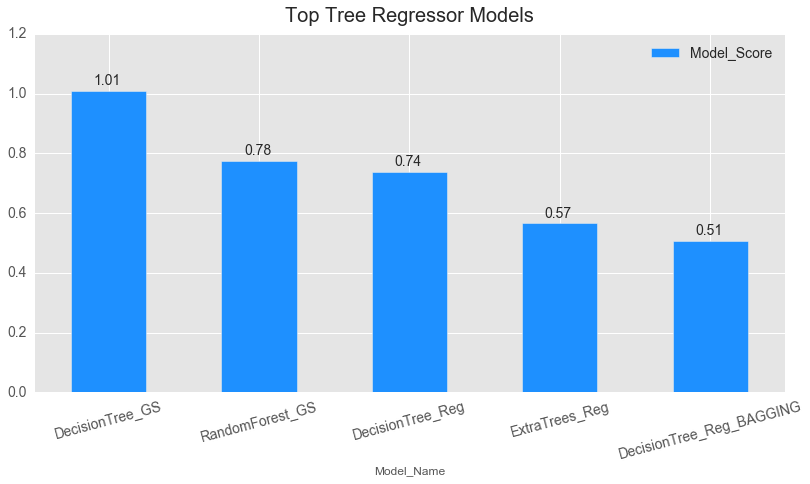

In [1066]:
fig, ax = plt.subplots(figsize=(12,6))

reg_df_short[['Model_Name', 'Model_Score']].plot(x=reg_df_short['Model_Name'],
                  kind='bar', ax=ax, rot=15, color='dodgerblue')
ax.set_title('Top Tree Regressor Models', fontsize=20, y =1.02)
ax.tick_params(axis='both', labelsize=14)
ax.legend(fontsize=14)
x_coords = [-.1, .9, 1.9, 2.9, 3.9]
for i,j in zip(x_coords, reg_df_short['Model_Score']):
    ax.annotate(str(round(j, 2)), xy=(i, j+.02), fontsize=14)

In [952]:
# def get_feature_importance(model):
#     model.fit(X,y)
#     model_features = pd.DataFrame(model.feature_importances_,
#                                  index=X.columns, columns=[str(model)[:12]])
#     model_features.sort_values(str(model)[:12], ascending=False, inplace=True)
#     top_features = model_features.iloc[:16, :]
#     return top_features

top_reg_features_df = pd.concat([GS_tree_features, GS_forest_features, tree_features, 
                            extra_features, bag_tree_features], axis=1)
top_reg_features_df.columns = ['GS_DecTree', 'GS_RandFor', 'DecTree', \
                               'DecTree_BAGGING', 'DecTree_BAGGINGG']
top_reg_features_df.sort_values('DecTree', ascending=False).head(10)

,GS_DecTree,GS_RandFor,DecTree,DecTree_BAGGING,DecTree_BAGGINGG
tomatoUserMeter,0.127926,0.197810,0.455333,0.296211,0.455333
tomatoUserReviews,NaN,0.023022,0.083229,0.044671,0.083229
tomatoReviews,NaN,0.031525,0.072662,0.021191,0.072662
Adj_Gross,0.085891,NaN,0.069110,NaN,0.069110
christophernolan,NaN,0.021732,0.044573,0.050928,0.044573
tomatoRating,NaN,0.026680,0.037676,0.012068,0.037676
Year,NaN,0.026167,0.033598,NaN,0.033598
action,NaN,NaN,0.015948,NaN,0.015948
Runtime,NaN,NaN,0.015489,NaN,0.015489
tomatoMeter,NaN,NaN,0.015259,NaN,0.015259


#### Top Regressor Features

In [1174]:
top_reg_features = top_reg_features_df.ix[
    ['tomatoUserMeter', 'tomatoUserRating',
     'tomatoFresh', 'tomatoReviews', 'tomatoRating',
    'Awards_Won', 'Adj_Gross', 'christophernolan'], :]
top_reg_features.head()

,GS_DecTree,GS_RandFor,DecTree,DecTree_BAGGING,DecTree_BAGGINGG
tomatoUserMeter,0.127926,0.197810,0.455333,0.296211,0.455333
tomatoUserRating,0.037759,0.037630,0.008389,0.025341,0.008389
tomatoFresh,NaN,0.032586,NaN,0.022681,NaN
tomatoReviews,NaN,0.031525,0.072662,0.021191,0.072662
tomatoRating,NaN,0.026680,0.037676,0.012068,0.037676


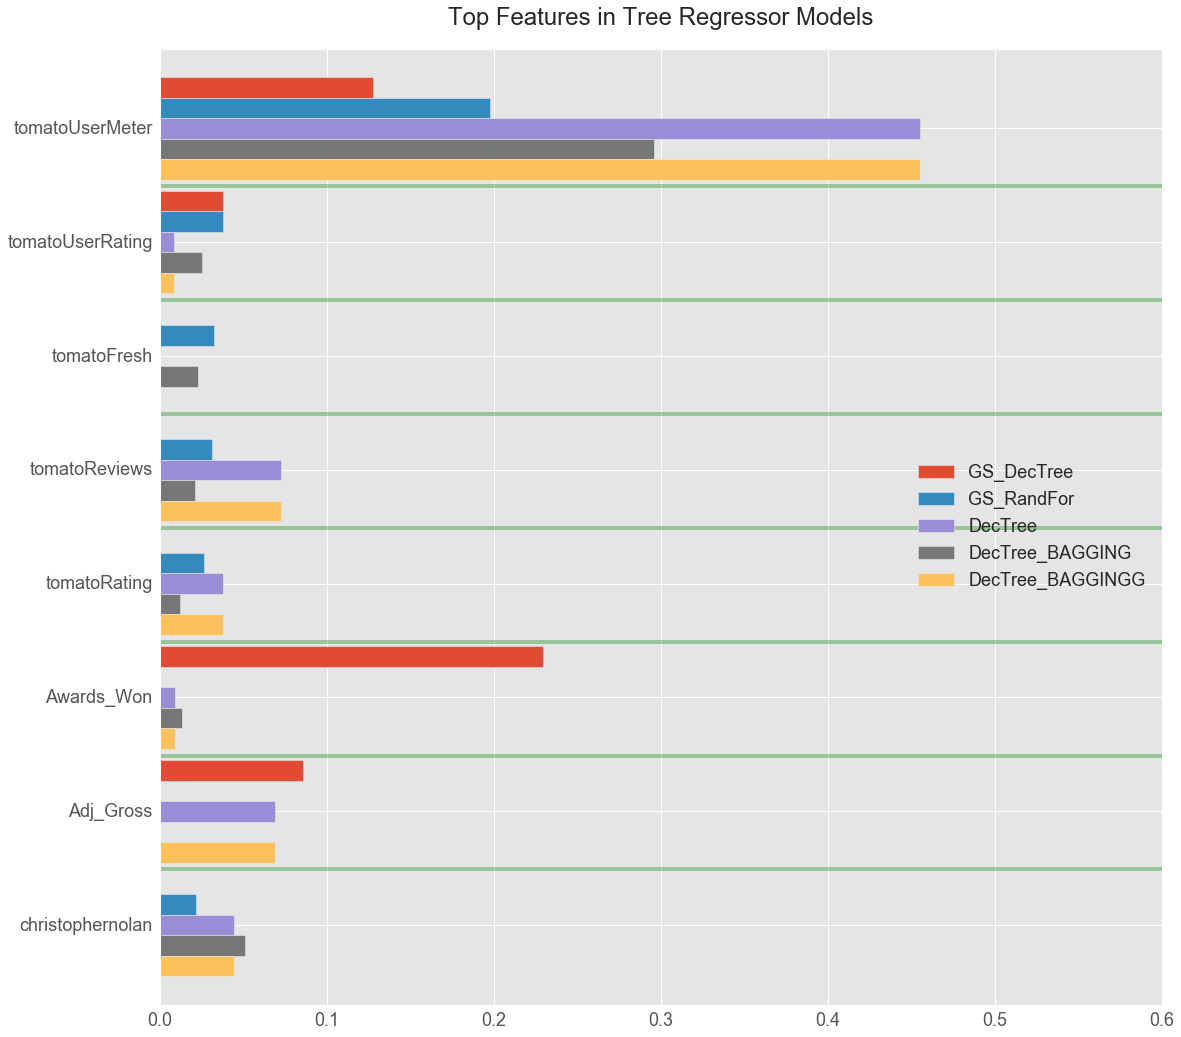

In [1176]:
fig, ax = plt.subplots(figsize=(16,16))
top_reg_features.plot(kind='barh', ax=ax, width=.9)
ax.set_title('Top Features in Tree Regressor Models', fontsize=24, y =1.02)
ax.tick_params(axis='both', labelsize=18)
ax.invert_yaxis()
ax.set_xlim(0, .6)
"""ax.set_xticklabels(['tomatoUserMeter', 'tomatoUserRating',
     'tomatoFresh', 'tomatoReviews', 'tomatoRating',
    'Awards_Won', 'joelcoen', 'christianbale',
    'Genre_Crime', 'Adj_Gross', 'columbiapictures', 
     'christophernolan'], fontsize=14, rotation=45)"""
ax.legend(fontsize=18, loc=7)
ax.hlines([.51, 1.51, 2.51, 3.51, 4.51, 5.51, 6.51], 
          0, 1, colors='green', alpha=.33)

## Classification

### Create new classification bins

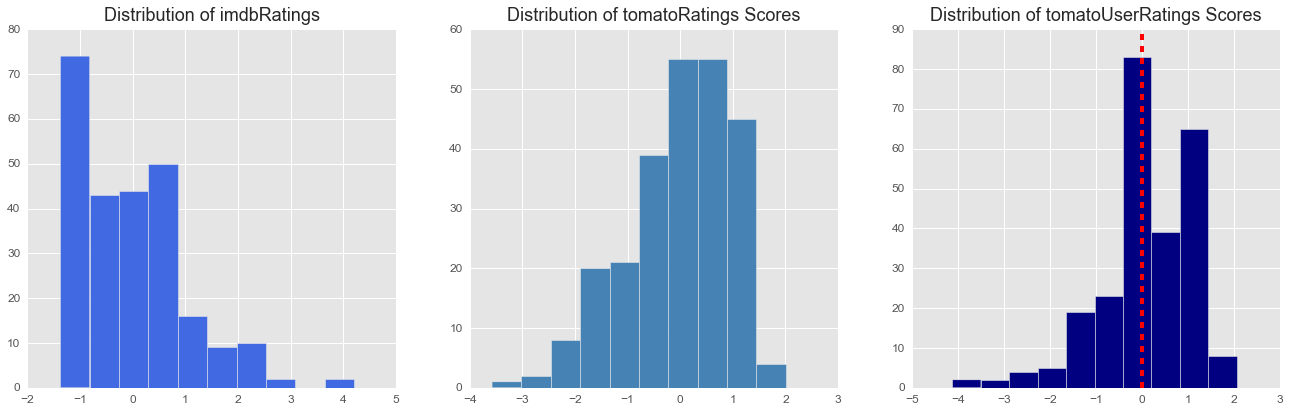

In [668]:
plt.style.use('ggplot')
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(20,6))

ax1.hist(df['imdbRating'], color='royalblue')
ax1.set_title('Distribution of imdbRatings', \
             fontsize=18, y=1.01)
ax1.tick_params(labelsize=12)

ax2.hist(df['tomatoRating'], color='steelblue')
ax2.set_title('Distribution of tomatoRatings Scores', \
             fontsize=18, y=1.01)
ax2.tick_params(labelsize=12)

ax3.hist(df['tomatoUserRating'], color='navy')
ax3.set_title('Distribution of tomatoUserRatings Scores', \
             fontsize=18, y=1.01)
ax3.tick_params(labelsize=12)
ax3.vlines(x=0, ymin=0, ymax=90, data=df['tomatoUserRating'], linestyles='dashed', color='red')

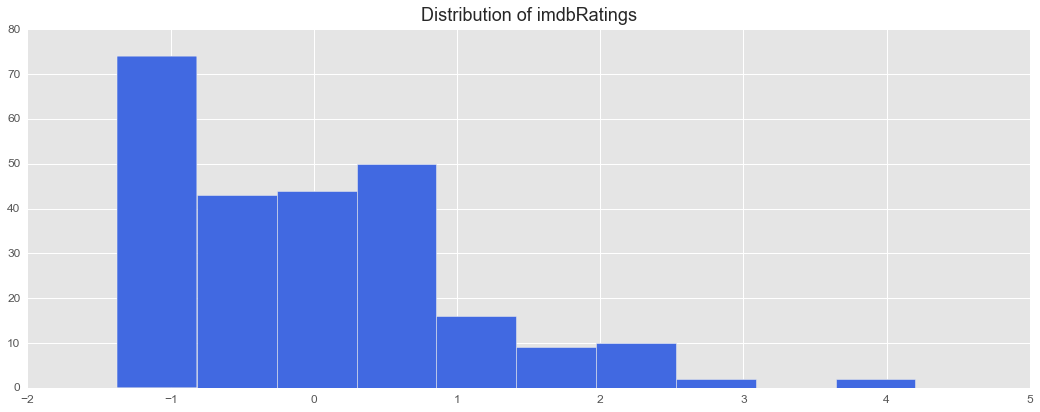

In [671]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(16,6))

imdbRating = df[df['imdbRating'] > 0]
ax.hist(df['imdbRating'], color='royalblue')
ax.set_title('Distribution of imdbRatings', \
             fontsize=18, y=1.01)
ax.tick_params(labelsize=12)

In [794]:
# Create three classification bins
average = df['imdbRating'].quantile(0.33)
good = df['imdbRating'].quantile(0.67)   
excellent = df['imdbRating'].quantile(1.0)   

def class_bins(x):
    if x <= average:
        return 'average'
    elif x <= good:
        return 'good'
    else:
        return 'excellent'
    
model_df1['rating'] = df['imdbRating'].apply(class_bins)
model_df1['rating'].head(3)

0    excellent
1    excellent
2    excellent
Name: rating, dtype: object

In [795]:
model_df1['rating'].value_counts()

average      117
good          68
excellent     65
Name: rating, dtype: int64

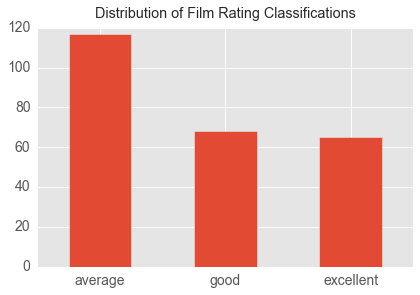

In [796]:
# Plot distribution of film classifications
model_df1['rating'].value_counts().plot(kind='bar')
plt.title('Distribution of Film Rating Classifications', y=1.02)
plt.xticks(fontsize=14, rotation=360)
plt.yticks(fontsize=14)

plt.savefig('classification_dist.png')

### Classifiers

In [801]:
print model_df1.columns

Index([             u'Year',        u'imdbRating',         u'imdbVotes',
             u'tomatoMeter',      u'tomatoRating',     u'tomatoReviews',
         u'tomatoUserMeter',  u'tomatoUserRating', u'tomatoUserReviews',
             u'tomatoFresh',
       ...
               u'Month_Feb',         u'Month_Jan',         u'Month_Jul',
               u'Month_Jun',         u'Month_Mar',         u'Month_May',
               u'Month_Nov',         u'Month_Oct',         u'Month_Sep',
                  u'rating'],
      dtype='object', length=200)


In [1122]:
# Set X and y
X = model_df1.drop(['imdbRating', 'imdbVotes', 'rating'], axis=1)
y = model_df1['rating']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    #random_state=7)

In [803]:
# classifier_list = [
#     ['DecisionTreeClassifier', DecisionTreeClassifier()],
#     ['RandomForestClassifier', RandomForestClassifier()],
#     ['AdaBoostClassifier', AdaBoostClassifier()],
#     ['GradientBoostingClassifier', GradientBoostingClassifier()]]

dtc = DecisionTreeClassifier(random_state=7)
rfc = RandomForestClassifier(random_state=7, n_jobs=-1)
adac = AdaBoostClassifier(random_state=7)
gradc = GradientBoostingClassifier(random_state=7)

classifier_dict = {dtc: 'DecisionTreeClassifier',
                   rfc: 'RandomForestClassifier',
                   adac: 'AdaBoostClassifier',
                   gradc: 'GradientBoostingClassifier'}

In [804]:
classifier_metrics = []

In [805]:
# Return cross_val_score from model
# Cannot add for loop in function as classifiers are not iterable
def run_classifier(classifier):
    score = cross_val_score(classifier, X, y, cv=cv, scoring='accuracy')
    mean = score.mean()
    std = score.std()
    classifier_metrics.append([classifier_dict[classifier], mean, std])
    return classifier_metrics

In [806]:
for i in classifier_dict:
    run_classifier(i)

classifier_metrics

[['RandomForestClassifier', 0.55200000000000005, 0.046647615158762396],
 ['GradientBoostingClassifier', 0.60400000000000009, 0.088904443083571469],
 ['DecisionTreeClassifier', 0.59999999999999998, 0.057965506984757768],
 ['AdaBoostClassifier', 0.51600000000000001, 0.066211781428987398]]

### GridSearch Classifiers

In [834]:
# def get_feature_importance_class(class_model):
#     #model.fit(X,y)
#     best_model = class_model.best_estimator_
#     model_features = pd.DataFrame(best_model.feature_importances_,
#                                  index=X.columns, columns=[str(class_model)[:12]])
#     model_features.sort_values(str(best_model)[:12], ascending=False, inplace=True)
#     top_features = model_features.iloc[:11, :]
#     return top_features

In [1124]:
GS_classifier_metrics = []

#### DecisionTree Classifier GS

In [1190]:
# DecisionTree GridSearch
parameters = {'max_depth':[5,6], 'max_features':[2,3,4], 
              'max_leaf_nodes':[8,9,10], 'min_samples_leaf':[1,2,3],
              'min_samples_split':[1, 2]}

class_tree_GS = GridSearchCV(dtc, param_grid=parameters, verbose=True, n_jobs=-1)
class_tree_GS.fit(X,y)
print class_tree_GS.best_params_
print class_tree_GS.best_score_

score = cross_val_score(class_tree_GS.best_estimator_, X, y, scoring='accuracy')
mean = score.mean()
std = score.std()
GS_classifier_metrics.append(['DecisionTreeClassifier_GS', mean, std])
GS_classifier_metrics

Fitting 3 folds for each of 108 candidates, totalling 324 fits
{'max_features': 3, 'max_leaf_nodes': 8, 'min_samples_split': 1, 'max_depth': 5, 'min_samples_leaf': 1}
0.468


[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:    2.1s finished


In [1135]:
best_model = class_tree_GS.best_estimator_
class_tree_GS_features = pd.DataFrame(best_model.feature_importances_,
index=X.columns, columns=['DTClassifier_GS'])
class_tree_GS_features.sort_values('DTClassifier_GS', ascending=False, inplace=True)
class_tree_GS_features = class_tree_GS_features.iloc[:16, :]
class_tree_GS_features.head()

,DTClassifier_GS
Awards_Won,0.302626
tomatoReviews,0.216162
Adj_Gross,0.169050
williamwyler,0.120588
Genre_Crime,0.079614


#### RandomForest Classifier GS

In [1136]:
# RandomForest GridSearch
parameters = {'max_depth':[4,5,6], 'max_features':[4,5,6], 
              'max_leaf_nodes':[8,10,12], 'min_samples_leaf':[1,2],
              'min_samples_split':[1]}

class_forest_GS = GridSearchCV(rfc, parameters, verbose=True, n_jobs=-1)
class_forest_GS.fit(X,y)

score = cross_val_score(class_forest_GS.best_estimator_, X, y, scoring='accuracy')
mean = score.mean()
std = score.std()
GS_classifier_metrics.append(['RandomForestClassifier_GS', mean, std])

print class_forest_GS.best_params_
GS_classifier_metrics

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   13.8s finished


{'max_features': 5, 'max_leaf_nodes': 8, 'min_samples_split': 1, 'max_depth': 5, 'min_samples_leaf': 1}


[['DecisionTreeClassifier_GS', 0.46815718157181574, 0.014718578319943531],
 ['RandomForestClassifier_GS', 0.56010452961672474, 0.017261166025205388]]

In [1137]:
best_model = class_forest_GS.best_estimator_
class_forest_GS_features = pd.DataFrame(best_model.feature_importances_,
index=X.columns, columns=['RFClassifier_GS'])
class_forest_GS_features.sort_values('RFClassifier_GS', ascending=False, inplace=True)
class_forest_GS_features = class_tree_GS_features.iloc[:16, :]
class_forest_GS_features.head()

,DTClassifier_GS
Awards_Won,0.302626
tomatoReviews,0.216162
Adj_Gross,0.169050
williamwyler,0.120588
Genre_Crime,0.079614


#### GradientBoost Classifier GS

In [1138]:
# GradientBoost Classifier GridSearch
parameters = {'max_depth':[3,4], 'max_features':[150,175], 
              'max_leaf_nodes':[15,18], 'min_samples_leaf':[1,2],
              'min_samples_split':[3,5]}

class_grade_GS = GridSearchCV(gradc, parameters, verbose=True, n_jobs=-1)
class_grade_GS.fit(X,y)

score = cross_val_score(class_grade_GS.best_estimator_, X, y, scoring='accuracy')
mean = score.mean()
std = score.std()
GS_classifier_metrics.append(['GradientBoostClassifier_GS', mean, std])

print class_grade_GS.best_params_
GS_classifier_metrics

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   22.6s finished


{'max_features': 150, 'max_leaf_nodes': 15, 'min_samples_split': 3, 'max_depth': 3, 'min_samples_leaf': 1}


[['DecisionTreeClassifier_GS', 0.46815718157181574, 0.014718578319943531],
 ['RandomForestClassifier_GS', 0.56010452961672474, 0.017261166025205388],
 ['GradientBoostClassifier_GS', 0.62824235385211002, 0.0219656730112919]]

In [1140]:
best_model = class_grade_GS.best_estimator_
class_grade_GS_features = pd.DataFrame(best_model.feature_importances_,
index=X.columns, columns=['GradeClassifier_GS'])
class_grade_GS_features.sort_values('GradeClassifier_GS', ascending=False, inplace=True)
class_grade_GS_features = class_grade_GS_features.iloc[:16,:]
class_grade_GS_features.head()

,GradeClassifier_GS
tomatoUserMeter,0.103832
tomatoUserReviews,0.086041
Runtime,0.068670
Adj_Gross,0.060361
Year,0.055866


### Bagging + GridSearch Classifier

In [860]:
bag_GS_metrics = []

In [861]:
# Bagged GS DecisionTree
classifier = BaggingClassifier(DecisionTreeClassifier())
classifier.fit(X,y)
parameters = {"base_estimator__max_depth": [1,5],
          "base_estimator__max_features": [1,2],
          "base_estimator__min_samples_leaf": [1,3],
          "base_estimator__min_samples_split": [2, 7],
          'max_features': [0.5, 0.7, 1.0],
          'max_samples': [0.5, 0.7, 1.0],
          'n_estimators': [2, 5, 10],
         }

big_classifier = GridSearchCV(classifier, param_grid=parameters, verbose=True)
big_classifier.fit(X,y)

score = cross_val_score(GS_classifier.best_estimator_, X, y, scoring='accuracy')
mean = score.mean()
std = score.std()
bag_GS_metrics.append(['DTClassifier_GS_BAGGED', mean, std])
bag_GS_metrics

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=1)]: Done 1296 out of 1296 | elapsed:   38.5s finished


[['DTClassifier_GS_BAGGED', 0.46418892760356173, 0.019321976996541881]]

In [862]:
# Bagged GS RandomForest
classifier = BaggingClassifier(RandomForestClassifier())
classifier.fit(X,y)
parameters = {"base_estimator__max_depth": [1,5],
          "base_estimator__max_features": [1,2],
          "base_estimator__min_samples_leaf": [1,3],
          "base_estimator__min_samples_split": [2, 7],
          'max_features': [0.5,1.0],
          'max_samples': [0.5,1.0],
          'n_estimators': [2,10],
         }

big_classifier = GridSearchCV(classifier, param_grid=parameters, verbose=True)
big_classifier.fit(X,y)

score = cross_val_score(GS_classifier.best_estimator_, X, y, scoring='accuracy', 
                       n_jobs=-1)
mean = score.mean()
std = score.std()
bag_GS_metrics.append(['RFClassifier_GS_BAGGED', mean, std])
bag_GS_metrics

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=1)]: Done 384 out of 384 | elapsed:  2.1min finished


[['DTClassifier_GS_BAGGED', 0.46418892760356173, 0.019321976996541881],
 ['RFClassifier_GS_BAGGED', 0.46418892760356173, 0.019321976996541881]]

### Classifier DataFrame

In [1141]:
GS_classifier_metrics

[['DecisionTreeClassifier_GS', 0.46815718157181574, 0.014718578319943531],
 ['RandomForestClassifier_GS', 0.56010452961672474, 0.017261166025205388],
 ['GradientBoostClassifier_GS', 0.62824235385211002, 0.0219656730112919]]

In [877]:
classification_metrics = []
classification_metrics.extend(classifier_metrics)
classification_metrics.extend(GS_classifier_metrics)
classification_metrics.extend(bag_GS_metrics)

In [878]:
classification_metrics

[['RandomForestClassifier', 0.55200000000000005, 0.046647615158762396],
 ['GradientBoostingClassifier', 0.60400000000000009, 0.088904443083571469],
 ['DecisionTreeClassifier', 0.59999999999999998, 0.057965506984757768],
 ['AdaBoostClassifier', 0.51600000000000001, 0.066211781428987398],
 ['DecisionTreeClassifier_GS', 0.46815718157181574, 0.014718578319943531],
 ['RandomForestClassifier_GS', 0.56010452961672474, 0.017261166025205388],
 ['GradientBoostClassifier_GS', 0.62824235385211002, 0.0219656730112919],
 ['DTClassifier_GS_BAGGED', 0.46418892760356173, 0.019321976996541881],
 ['RFClassifier_GS_BAGGED', 0.46418892760356173, 0.019321976996541881]]

In [1085]:
class_df = pd.DataFrame(classification_metrics, 
                        columns=['Model_Name', 'Model_Score', 'Score_Std'])
class_df.sort_values('Model_Score', ascending=False)

,Model_Name,Model_Score,Score_Std
6,GradientBoostClassifier_GS,0.628242,0.021966
1,GradientBoostingClassifier,0.604000,0.088904
2,DecisionTreeClassifier,0.600000,0.057966
5,RandomForestClassifier_GS,0.560105,0.017261
0,RandomForestClassifier,0.552000,0.046648
3,AdaBoostClassifier,0.516000,0.066212
4,DecisionTreeClassifier_GS,0.468157,0.014719
7,DTClassifier_GS_BAGGED,0.464189,0.019322
8,RFClassifier_GS_BAGGED,0.464189,0.019322


In [1087]:
class_df_short = class_df.sort_values('Model_Score', ascending=False).ix[[6,1,2,5,0], :]
class_df_short.head()

,Model_Name,Model_Score,Score_Std
6,GradientBoostClassifier_GS,0.628242,0.021966
1,GradientBoostingClassifier,0.604000,0.088904
2,DecisionTreeClassifier,0.600000,0.057966
5,RandomForestClassifier_GS,0.560105,0.017261
0,RandomForestClassifier,0.552000,0.046648


In [1086]:
reg_median = reg_df['Model_Score'].median()
class_median = class_df['Model_Score'].median()
print reg_median
print class_median

0.500272266369
0.552


#### Top Tree Classifiers Plot

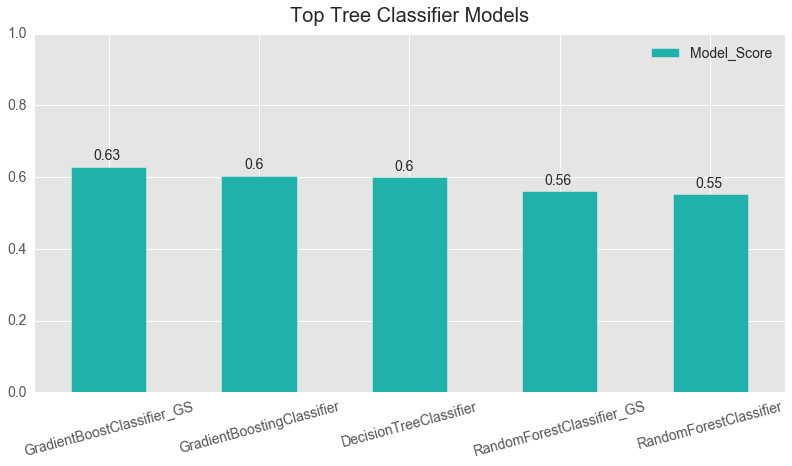

In [1108]:
fig, ax = plt.subplots(figsize=(12,6))

class_df_short[['Model_Name', 'Model_Score']].plot(x=class_df_short['Model_Name'],
                  kind='bar', ax=ax, rot=15, color='lightseagreen')
ax.set_title('Top Tree Classifier Models', fontsize=20, y =1.02)
ax.tick_params(axis='both', labelsize=14)
ax.legend(fontsize=14)
ax.set_ylim(bottom=0, top=1.0)
ax.set_xlabel('', labelpad=20)
x_coords = [-.1, .9, 1.9, 2.9, 3.9]
for i,j in zip(x_coords, class_df_short['Model_Score']):
    ax.annotate(str(round(j, 2)), xy=(i, j+.02), fontsize=14)

#### Top Classifier Features

In [1120]:
print class_grade_GS_features.shape
print class_gradc_features.shape 
print class_tree_features.shape 
print class_forest_GS_features.shape
print class_forest_features.shape

(197, 1)
(16, 1)
(16, 1)
(197, 1)
(16, 1)


In [ ]:
class_tree_features = get_feature_importance(dtc)
class_forest_features = get_feature_importance(rfc)
class_ada_features = get_feature_importance(adac)
class_gradc_features = get_feature_importance(gradc)

In [1179]:
class_features_df = pd.concat([class_grade_GS_features, class_gradc_features, 
                               class_tree_features, class_forest_GS_features,
                              class_forest_features], axis=1)
class_features_df.sort_values('DTClassifier_GS', ascending=False).head(10)

,GradeClassifier_GS,GradientBoos,DecisionTree,DTClassifier_GS,RandomForest
Awards_Won,0.026245,0.018877,0.045877,0.302626,0.033819
tomatoReviews,0.033775,0.046790,0.052810,0.216162,0.044617
Adj_Gross,0.060361,0.058545,0.025739,0.169050,0.041143
williamwyler,NaN,NaN,NaN,0.120588,NaN
Genre_Crime,NaN,NaN,NaN,0.079614,NaN
Month_Sep,NaN,NaN,NaN,0.062077,NaN
martinscorsese,NaN,NaN,NaN,0.049883,NaN
history,NaN,NaN,NaN,0.000000,NaN
horror,NaN,NaN,NaN,0.000000,NaN
music,0.014193,0.015045,NaN,0.000000,NaN


In [1180]:
top_class_features = class_features_df.ix[
    ['tomatoUserMeter', 'tomatoUserReviews', 'Runtime', 
     'Adj_Gross', 'Year', 'tomatoReviews']]

top_class_features.head()

,GradeClassifier_GS,GradientBoos,DecisionTree,DTClassifier_GS,RandomForest
tomatoUserMeter,0.103832,0.116015,0.209785,NaN,0.071109
tomatoUserReviews,0.086041,0.078327,0.081701,NaN,0.050514
Runtime,0.068670,0.068590,0.118566,NaN,0.065154
Adj_Gross,0.060361,0.058545,0.025739,0.16905,0.041143
Year,0.055866,0.046847,0.053887,NaN,0.040306


(0, 0.4)

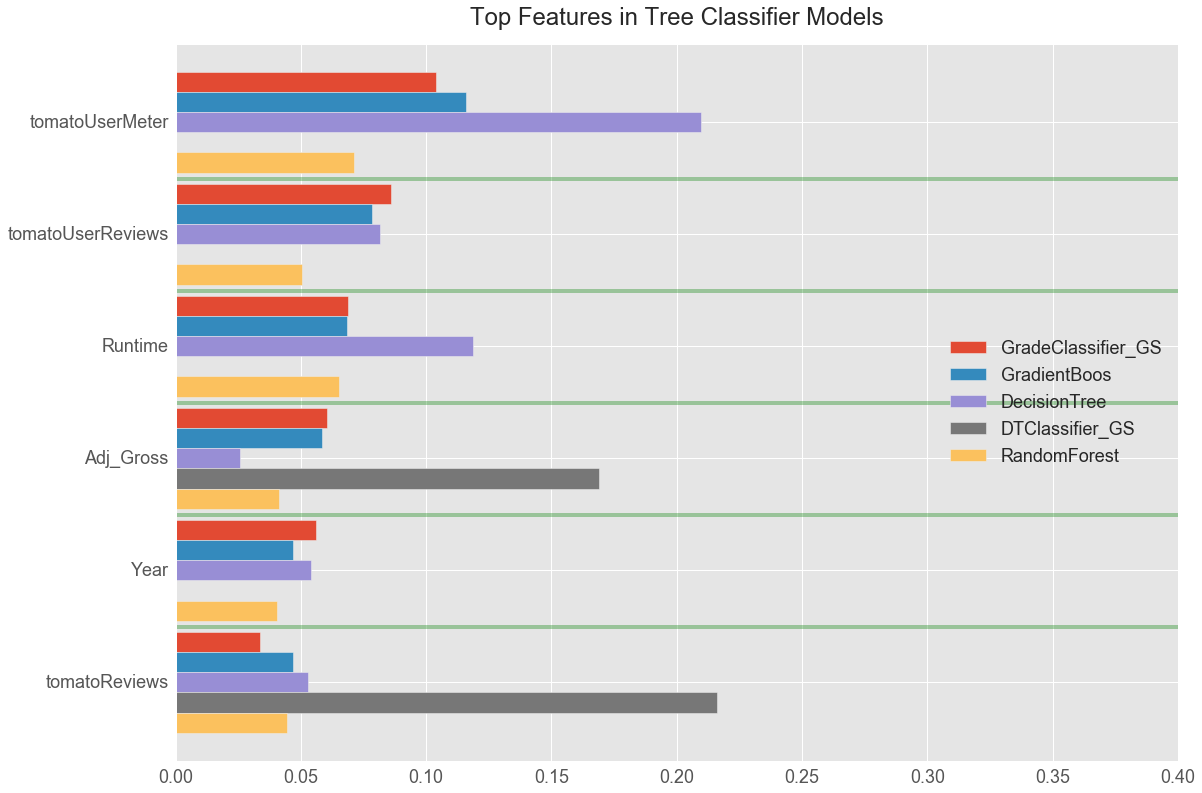

In [1187]:
fig, ax = plt.subplots(figsize=(16,12))
top_class_features.plot(kind='barh', ax=ax, width=.9)
ax.set_title('Top Features in Tree Classifier Models', fontsize=24, y =1.02)
ax.tick_params(axis='both', labelsize=18)
ax.invert_yaxis()
ax.legend(fontsize=18, loc=7)
ax.hlines([.51, 1.51, 2.51, 3.51, 4.51], 0, 1, colors='green', alpha=0.33)
ax.set_xlim(0, .4)

### Classification Matrix

In [1204]:
classes = list(dtc.classes_)
classes


['average', 'excellent', 'good']

In [1244]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=None)

class_tree_GS.fit(X_train, y_train)
y_pred = class_tree_GS.predict(X_test)
y_true = y_test
cm = np.array(confusion_matrix(y_true, y_pred))

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:    1.5s finished


In [1246]:
confusion = pd.DataFrame(cm, index=classes, columns=['pred_' + i for i in classes])
confusion

,pred_average,pred_excellent,pred_good
average,31,5,2
excellent,14,4,1
good,15,2,1


In [1247]:
confusion.sum()

pred_average      60
pred_excellent    11
pred_good          4
dtype: int64

In [1218]:
len(y_test)

75

In [1242]:
import itertools

class_names = classes
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16, y=1.02)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    print('Confusion matrix')
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],fontsize=14,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    # Plot non-normalized confusion matrix
    plt.figure()


Confusion matrix
[[31  5  2]
 [14  4  1]
 [15  2  1]]


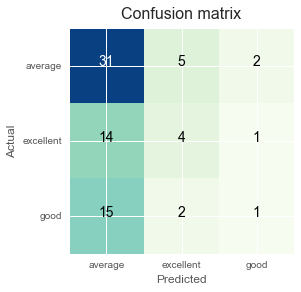

In [1248]:
plot_confusion_matrix(cm, classes=classes)